Six-Hump Camel synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/camel6.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'SixHumpCamel'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    operator = -1
    y_lb = -1.0316 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb_x1 = -3 
    ub_x1 = +3
    lb_x2 = -2 
    ub_x2 = +2

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}

# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
        

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y \t GP EI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def acqfuncApproxMeanTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = df1 + df2

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApproxMeanTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncApprox_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncApprox_exploit)
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        min_acqfuncApprox_exploit = self.min_acqfuncApprox_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
            min_acqfuncApprox_exploit = BOLD + OKGREEN + str(min_acqfuncApprox_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox, min_acqfuncApprox_exploit))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP dEI: maximum y \t GP dEI: exploit'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncExactExploitTerm(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        gamma = (new_mean - self.tau - eps) / (new_std + eps) 
        
        dm, ds = self.GP.AcqGrad(xnew)
        dsdx = ds / (2 * (new_std + eps))
        dmdx = (dm - gamma * dsdx) / (new_std + eps)
            
        f = (new_std + eps) * (gamma * norm.cdf(gamma))
        df1 = norm.cdf(gamma) * gamma * dsdx
        df2 = (new_std + eps) * (norm.cdf(gamma) * dmdx + norm.pdf(gamma) * gamma)
        df = -(df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return -f, np.asarray(df_arr).transpose()

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
        opt_exploit = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExactExploitTerm,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        f_best_exploit = np.array([np.atleast_1d(res.fun)[0] for res in opt_exploit])
        self.f_best_exploit = f_best_exploit
        self.min_acqfuncExact_exploit = -min(self.f_best_exploit)
        self.history.append(self.min_acqfuncExact_exploit)
            
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        min_acqfuncExact_exploit = self.min_acqfuncExact_exploit
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
            min_acqfuncExact_exploit = BOLD + OKGREEN + str(min_acqfuncExact_exploit) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact, min_acqfuncExact_exploit))

    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.19209699 -0.31431616]	 2.418604194089478	 -0.2650082867644827	 1.5097990090803877	 0.9188024152555437
2  	 [-0.22547579  1.70883971]	 22.240849622618942	 -0.2650082867644827	 0.7046348253537699	 -3.18617719852186e-20
3  	 [ 2.48246431 -1.70176508]	 40.65026890583644	 -0.2650082867644827	 0.6723744435129764	 -2.580485742773404e-80
4  	 [3. 2.]	 162.89999999999998	 -0.2650082867644827	 0.6723360499298292	 -1.3838913333865292e-190
5  	 [-3.  2.]	 150.89999999999998	 -0.26

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.39431495 -0.08552524]	 0.5771014397304058	 0.011939608840498828	 0.906568619126185	 0.16886228428524486
2  	 [ 1.85203999 -0.19665791]	 1.9520503538370169	 0.011939608840498828	 0.8038997384103904	 0.006208404590324406
3  	 [0.73875436 2.        ]	 51.08923695270019	 0.011939608840498828	 0.8038430929767131	 0.005972625477217093
4  	 [ 3. -2.]	 150.89999999999998	 0.011939608840498828	 0.8036905829278483	 0.00581941657059811
5  	 [-3.  2.]	 150.89999999999998	 0.0

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.2309166   0.29148206]	 -0.1709116466540207	 -0.2431922946563294	 0.9349098832252827	 0.22236108255766499
2	 [-0.39661821  0.85835803]	 -0.5376275334725007	 -0.5376275334725007	 0.7838215742349248	 0.11260893335953688
3  	 [-0.2056751   0.24083065]	 -0.10259843772453653	 -0.5376275334725007	 0.6200781888247454	 -8.926694500467198e-24
4  	 [-0.53334414  1.38957085]	 7.424435674743689	 -0.5376275334725007	 0.6048660517528813	 -1.1947690501782786e-26
5  	 [ 0.02178151 -0.239832

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [ 0.13819595 -1.09159236]	 0.8378729983345513	 0.8378729983345513	 3.7916921413335207	 3.684891882473408
2	 [ 0.16279961 -1.07402786]	 0.6381310288891437	 0.6381310288891437	 1.4908153932174946	 0.9767803202631784
3  	 [-3.  2.]	 150.89999999999998	 0.6381310288891437	 1.1409869665791987	 0.49880683286920197
4  	 [-3. -2.]	 162.89999999999998	 0.6381310288891437	 1.1311537715140516	 0.5539689936175095
5	 [-0.26848645 -0.13256574]	 0.24408538465589355	 0.24408538465589355	 1.42176205865

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.32583964 1.00818374]	 0.7967371894748262	 -0.6512780061070701	 0.523408070519103	 -1.693962554295879e-07
2  	 [ 3. -2.]	 150.89999999999998	 -0.6512780061070701	 0.5131927061669258	 -1.9718622393957618e-07
3  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 0.508620246487194	 -2.1274764913661798e-265
4  	 [0.4254109 0.0313057]	 0.6664962659071133	 -0.6512780061070701	 0.4887484722236481	 -1.7841268738158813e-65
5  	 [-3. -2.]	 162.89999999999998	 -0.6512780061070701	 0.42

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.19888424 0.91003727]	 -0.23327669759911474	 -0.3096187466378422	 0.7522208865862204	 0.003127391473709932
2	 [0.11616366 0.67403998]	 -0.8597635887265809	 -0.8597635887265809	 0.6621933034826909	 -1.1360177718910707e-11
3  	 [0.13061593 0.7053691 ]	 -0.8402109420699337	 -0.8597635887265809	 0.4609708623254385	 -1.1001710103484286e-13
4  	 [0.13127649 0.70690988]	 -0.8388869519432485	 -0.8597635887265809	 0.4803783256048184	 -5.695663322062996e-13
5  	 [0.13174677 0.708

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.14003009 1.65200772]	 19.18503288903285	 -0.46481072558790276	 0.6285586421843669	 -2.7342928706042297e-10
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 0.5869305043864016	 -0.18969464864866273
3  	 [-0.47109136  0.58002622]	 -0.3783020334196958	 -0.46481072558790276	 0.6533643807880518	 -2.970760562160921e-33
4	 [-0.14196887  0.42856901]	 -0.5808180226262771	 -0.5808180226262771	 0.620625425244183	 -2.7362527767352515e-13
5  	 [-0.35

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1  	 [-0.77086886  0.84272184]	 0.23242422233356008	 0.03190064766213015	 0.91523883411738	 0.16304433145541153
2  	 [-3.  2.]	 150.89999999999998	 0.03190064766213015	 0.8081807517734181	 0.05405622153987977
3	 [-0.24360329  0.39126551]	 -0.38387907993258125	 -0.38387907993258125	 0.9759772757460892	 0.3369673502044986
4  	 [-0.24416435  0.38712394]	 -0.3730716827364074	 -0.38387907993258125	 0.686632366675899	 0.045499183942687066
5  	 [-0.24497437  0.38151423]	 -0.3583721394862776

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.19950386 1.29272168]	 4.899980086595864	 1.395407492769129	 1.6825554726423106	 1.057126604330861
2  	 [ 3.         -0.21547441]	 108.07648258328325	 1.395407492769129	 1.6820245197700332	 1.0564403128392896
3  	 [-1.44939862  2.        ]	 47.32689265929798	 1.395407492769129	 1.5059197460104214	 0.8311636268008732
4  	 [-1.57484893 -2.        ]	 53.238148922947346	 1.395407492769129	 1.0433687877426328	 -4.07714106958632e-98
5	 [-0.51196048 -0.15338005]	 0.8967863571366157	 0.8967863

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.242737374749332	 0.5021663084364411
2  	 [-3.  2.]	 150.89999999999998	 0.7775687473184012	 1.2003547477215273	 0.4550285164173864
3  	 [ 3.         -0.56605295]	 106.33084289570883	 0.7775687473184012	 1.2462221349744769	 0.5064166519415918
4	 [-0.7532562   0.62545309]	 0.23063111601765074	 0.23063111601765074	 4.702602429096982	 4.666427165520929
5  	 [-0.77425414  0.62943659]	 0.27078525420625343	 0.23063111601765074	 2.36216611

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [ 1.79052491 -2.        ]	 46.642439808247566	 -0.6254688257880329	 0.5012187568587065	 -3.1088135992620363e-130
2  	 [-0.41855111  2.        ]	 47.800981468687965	 -0.6254688257880329	 0.4990340161834902	 -1.0501755657702141e-84
3  	 [ 0.09051383 -0.00503656]	 0.03207290039322645	 -0.6254688257880329	 0.5878057730786099	 -3.7372728714887694e-132
4  	 [ 0.08003266 -0.00212966]	 0.025346253591978556	 -0.6254688257880329	 0.4792252975615052	 -4.109435696098485e-152
5  	 [ 0.074

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.337878    0.82388566]	 0.36879704199305774	 0.36879704199305774	 2.6078869720887123	 2.3170060831443857
2  	 [1.74301928 2.        ]	 53.60261104768335	 0.36879704199305774	 0.9958062237839763	 0.2113717015114936
3  	 [-3. -2.]	 162.89999999999998	 0.36879704199305774	 0.9956543245697344	 0.3418721269701908
4  	 [-0.16291724 -2.        ]	 48.430529410549696	 0.36879704199305774	 0.988297440269319	 0.3446372111245051
5	 [-1.49393438  0.64566136]	 0.23577047222883796	 0.235770472

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.69815135 -1.5584218 ]	 14.280544136905649	 0.752930921147986	 2.68563201296615	 2.380791694546714
2  	 [-3.  2.]	 150.89999999999998	 0.752930921147986	 1.2302321816711441	 0.48693089954324686
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.2302321776790974	 0.48693085799253094
4  	 [-1.32681869 -1.1815997 ]	 6.132474358637779	 0.752930921147986	 1.2302321819970747	 0.4869313776555921
5	 [-0.19817028  0.59883805]	 -0.8848366775560662	 -0.8848366775560662	 1.2251818292022054	 0.5159

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
5  	 [ 0.10283639 -0.51837162]	 -0.79725

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1  	 [-0.31230925  1.23090386]	 3.107966059914712	 2.1163170846379233	 2.2682349603974403	 1.8149407448690968
2  	 [3. 2.]	 162.89999999999998	 2.1163170846379233	 2.2652732718226036	 1.809439395497574
3  	 [-3.  2.]	 150.89999999999998	 2.1163170846379233	 2.2467674329839866	 1.7857035036451063
4	 [-0.27070757 -0.29550408]	 0.04318936470340434	 0.04318936470340434	 2.966959336757291	 2.750773192836854
5  	 [-0.27822716 -0.29112708]	 0.06792524325045923	 0.04318936470340434	 0.94568852

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.04378922]	 108.7609770576423	 1.8632773736203017	 2.053886212873812	 1.5372829420695178
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.047899482520367	 1.5295228874602356
3  	 [0.53255234 2.        ]	 50.03824175828417	 1.8632773736203017	 2.042164250384682	 1.5220959456454406
4  	 [-0.91745731 -0.01809519]	 2.093131287996447	 1.8632773736203017	 1.485430760028271	 -0.0
5  	 [-1.03036552 -0.06609219]	 2.329255444267561	 1.8632773736203017	 1.011726566636

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1	 [-0.55712466  1.08599903]	 1.2904712864486778	 1.2904712864486778	 2.4395876955173423	 2.0765525416326844
2  	 [ 3. -2.]	 150.89999999999998	 1.2904712864486778	 1.5912883774316626	 0.9398848862297376
3  	 [3. 2.]	 162.89999999999998	 1.2904712864486778	 1.524132247295509	 0.8582322459311009
4  	 [0.92241907 0.18981443]	 2.1246079247590357	 1.2904712864486778	 1.4178588579102105	 0.7294223633368577
5  	 [-1.56013619  2.        ]	 46.98120007046126	 1.2904712864486778	 1.4242832287494782

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-3.  2.]	 150.89999999999998	 2.062169771852028	 2.2168306774450874	 1.747261660410442
2	 [ 0.51933718 -0.47021367]	 -0.0004387791505781058	 -0.0004387791505781058	 1.022904098881382	 0.32392084914507635
3	 [ 0.46722715 -0.47742819]	 -0.15039958734018488	 -0.15039958734018488	 0.33973799744242655	 -3.643525355348516e-53
4	 [ 0.44976542 -0.47473192]	 -0.1858510183284554	 -0.1858510183284554	 0.36646653580790994	 -1.1203601329461037e-35
5	 [ 0.44009002 -0.47280303]	 -0.2039971659151858	 -0.20399

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [-0.04594902  2.        ]	 47.916537858903055	 6.578088852480828	 5.923965955295372	 5.916007521918661
2  	 [ 1.6626862 -2.       ]	 46.725988988445636	 6.578088852480828	 6.421344447472726	 6.416734173111807
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 4.553585229212489	 4.49710716890754
4	 [-0.30754482 -0.24340017]	 0.21175163798172386	 0.21175163798172386	 3.328302393361501	 3.130975259042787
5	 [-0.23874691 -0.2198156 ]	 0.08978273567635284	 0.08978273567635284	 0.1845406628

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 	 GP EI: exploit
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.16287628 -2.        ]	 52.71897154250457	 1.5037392797834441	 1.6228041681659169	 0.9826089132045954
2  	 [ 3. -2.]	 150.89999999999998	 1.5037392797834441	 1.6680546482650702	 1.0395838184931585
3	 [ 0.44491632 -0.32008893]	 0.2018495674177776	 0.2018495674177776	 0.7085212854773342	 -2.106634772521456e-27
4  	 [ 0.44440555 -0.31347918]	 0.21688155478608212	 0.2018495674177776	 0.3543859013301198	 -1.8279435545685347e-131
5  	 [ 0.44473351 -0.31307702]	 0.21870341240075275	 0.201

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.49786797  0.88129797]	 -0.2650082867644827	 -0.2650082867644827	    	    
init	 [-2.99931375 -0.79066971]	 110.13991869176735	 -0.2650082867644827	    	    
init	 [-2.11946466 -1.63064562]	 26.90935479429681	 -0.2650082867644827	    	    
init	 [-1.88243873 -0.61775709]	 2.8558363102363344	 -0.2650082867644827	    	    
init	 [-0.61939515  0.15526694]	 1.0540522096005847	 -0.2650082867644827	    	    
1  	 [-1.0222508  -0.56767233]	 1.9738149569435763	 -0.2650082867644827	 1.337802723187696	 0.629264713123948
2  	 [-1.26808267 -0.11971967]	 2.4833208094638186	 -0.2650082867644827	 0.8119767266061961	 0.11076026209454763
3  	 [-0.4682545   1.65874906]	 19.278966809435275	 -0.2650082867644827	 0.7060383202615662	 -1.6942665220706295e-82
4  	 [0.57640459 0.14873338]	 1.108587133549329	 -0.2650082867644827	 0.6973396676340106	 -1.6684030070570907e-190
5  	 [3. 2.]	 162.8999999

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-0.38403059 -1.89629507]	 38.61280125654363	 0.011939608840498828	    	    
init	 [ 0.29797487 -0.25871043]	 0.011939608840498828	 0.011939608840498828	    	    
init	 [-0.47779319 -0.67866072]	 0.1381453419305213	 0.011939608840498828	    	    
init	 [-1.7721082   0.47708387]	 0.626144759281101	 0.011939608840498828	    	    
init	 [-1.20207196 -0.9326909 ]	 3.0693811601417798	 0.011939608840498828	    	    
1  	 [-0.31993922 -0.13822595]	 0.35705703278801193	 0.011939608840498828	 0.9015114982733211	 0.16872520426363652
2  	 [ 2.04712486 -0.34678071]	 3.2819773046713774	 0.011939608840498828	 0.8038736053985057	 0.006000197446719373
3  	 [0.87539145 2.        ]	 51.73283837601235	 0.011939608840498828	 0.803856887569106	 0.00598624055551247
4  	 [-3. -2.]	 162.89999999999998	 0.011939608840498828	 0.8034960174697786	 0.01740853292694663
5  	 [3.         1.37226805]	 119.668

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.30478742 0.83259129]	 -0.2431922946563294	 -0.2431922946563294	    	    
init	 [-1.25457157  0.04331042]	 2.3313310458730996	 -0.2431922946563294	    	    
init	 [2.35768173 1.58517236]	 33.54152175045586	 -0.2431922946563294	    	    
init	 [-2.24648814 -1.17102849]	 14.214109412296352	 -0.2431922946563294	    	    
init	 [-2.69119678 -0.23676063]	 45.87579771712209	 -0.2431922946563294	    	    
1  	 [-0.24615031  0.33088407]	 -0.23671242014455512	 -0.2431922946563294	 0.9345839458281968	 0.08194134069705998
2	 [-0.26381503  0.4354689 ]	 -0.4612393470974674	 -0.4612393470974674	 0.7867737753492747	 0.06040329168988206
3  	 [-0.51799266  1.2341212 ]	 3.4758193603861836	 -0.4612393470974674	 0.6561897207749525	 0.0022605811072868433
4  	 [-0.0673234  -0.21593135]	 -0.14518543952304563	 -0.4612393470974674	 0.7615632543494404	 0.05185450802413667
5  	 [ 0.05023894 -0.2931929

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [2.80217903 0.188929  ]	 63.70212732873661	 2.3196402150601703	    	    
init	 [2.83610616 0.85926397]	 71.43837110827245	 2.3196402150601703	    	    
init	 [ 1.18637295 -1.13564202]	 2.5463267765341566	 2.3196402150601703	    	    
init	 [ 2.85764673 -1.97507898]	 113.76785286351424	 2.3196402150601703	    	    
init	 [-1.48210583 -0.26083387]	 2.3196402150601703	 2.3196402150601703	    	    
1	 [-0.19248638 -0.29673967]	 -0.118746904624908	 -0.118746904624908	 2.801662033633455	 2.5125182578949046
2	 [ 0.0771446 -0.9683799]	 -0.2844404270558513	 -0.2844404270558513	 1.4618491526354545	 0.7582442586464574
3  	 [ 0.15454763 -1.42856043]	 8.369638169079648	 -0.2844404270558513	 1.0080760300974796	 0.342484671233503
4  	 [-0.59840288  1.94539575]	 42.167704564580156	 -0.2844404270558513	 0.6339682859220072	 -9.93327859073916e-235
5  	 [-3. -2.]	 162.89999999999998	 -0.284440427

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-1.66804097  1.48292922]	 10.126030408244933	 -0.6512780061070701	    	    
init	 [-1.75968507  1.67444363]	 19.4300499315822	 -0.6512780061070701	    	    
init	 [-0.06953287  0.44697545]	 -0.6512780061070701	 -0.6512780061070701	    	    
init	 [1.59544714 0.07367195]	 2.168775388880503	 -0.6512780061070701	    	    
init	 [-1.21919699 -1.24911509]	 7.420330936884148	 -0.6512780061070701	    	    
1  	 [0.27873899 1.08341635]	 1.4162287546962613	 -0.6512780061070701	 0.5212081300221553	 -1.693962554295879e-07
2  	 [3. 2.]	 162.89999999999998	 -0.6512780061070701	 0.5110424854660709	 -0.007693401585749041
3  	 [ 2.22867989 -2.        ]	 52.44856270446538	 -0.6512780061070701	 0.5135688175365126	 -1.0901773356602586e-10
4  	 [0.27494103 0.1639579 ]	 0.23095496884843886	 -0.6512780061070701	 0.4391275416005083	 -1.7259045920241207e-64
5  	 [-3. -2.]	 162.89999999999998	 -0.651

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.35716091 -0.67208078]	 11.995980169715628	 -0.3096187466378422	    	    
init	 [ 1.92737474 -1.8332135 ]	 31.167927894156623	 -0.3096187466378422	    	    
init	 [-2.35405992  0.38020826]	 13.013381745677465	 -0.3096187466378422	    	    
init	 [ 0.17890417 -0.32477029]	 -0.3096187466378422	 -0.3096187466378422	    	    
init	 [-0.9875529   0.49007773]	 0.9989196280666852	 -0.3096187466378422	    	    
1  	 [0.14564833 0.99656045]	 0.20177881687152865	 -0.3096187466378422	 0.7490117988921283	 0.0010812092295807289
2  	 [3. 2.]	 162.89999999999998	 -0.3096187466378422	 0.624361690543775	 -1.1358168780510443e-11
3	 [-0.20642557  0.73264737]	 -0.9791695830839107	 -0.9791695830839107	 0.5720634054283468	 -0.0
4  	 [-0.1567979   0.53674031]	 -0.8074587029374714	 -0.9791695830839107	 0.4034354809521641	 -1.6535923561483e-22
5  	 [-0.08928664  0.26902626]	 -0.2608132060388308	 -0

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.54215026  1.11967517]	 26.53843863832488	 -0.46481072558790276	    	    
init	 [-0.36954461  0.89386071]	 -0.46481072558790276	 -0.46481072558790276	    	    
init	 [2.86793707 0.15398348]	 76.66051064695093	 -0.46481072558790276	    	    
init	 [ 0.00672278 -1.71179547]	 22.613010892757885	 -0.46481072558790276	    	    
init	 [-1.38936612e+00 -4.69996698e-04]	 2.294585534557751	 -0.46481072558790276	    	    
1  	 [0.1310842  1.64834684]	 18.945381193780257	 -0.46481072558790276	 0.6285322890609756	 -2.7342928706042297e-10
2  	 [-2.0069916  -0.34039291]	 4.09787808897999	 -0.46481072558790276	 0.5869305043864016	 -0.18969464864866273
3  	 [-0.62752856  0.70661994]	 -0.17355017380823146	 -0.46481072558790276	 0.6492442081456917	 -1.192481621421512e-06
4	 [-0.29852921  0.52826691]	 -0.6224198225575582	 -0.6224198225575582	 0.6233739906842195	 -5.81192409654036e-09
5  	 [-3

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [2.24057642 1.87416265]	 48.82879577505094	 0.03190064766213015	    	    
init	 [2.21516724 0.12342277]	 8.660623551418242	 0.03190064766213015	    	    
init	 [-1.60363003 -1.95440478]	 48.28332373939171	 0.03190064766213015	    	    
init	 [-0.41718709 -0.39059456]	 0.2801229037700297	 0.03190064766213015	    	    
init	 [ 0.13604803 -0.08643282]	 0.03190064766213015	 0.03190064766213015	    	    
1	 [-0.57246742  0.6534526 ]	 -0.25569579328253045	 -0.25569579328253045	 0.9022574499586161	 0.16080467174744836
2  	 [-1.18831557  1.21804401]	 3.8222330710419667	 -0.25569579328253045	 0.6921018395852151	 -6.791361360733351e-42
3  	 [0.04982841 0.04620172]	 0.003700531824410219	 -0.25569579328253045	 0.5314874765523403	 -3.857814849553308e-42
4  	 [ 1.5233709  -1.90834873]	 37.71548823920068	 -0.25569579328253045	 0.5544341266061554	 -2.886206121009707e-43
5	 [-0.33912575  0.434

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.93775508  0.00749837]	 92.35857237145763	 1.395407492769129	    	    
init	 [-0.02536024 -1.46468188]	 9.867672894921913	 1.395407492769129	    	    
init	 [-2.14733349 -1.1257653 ]	 10.24680089963123	 1.395407492769129	    	    
init	 [-0.48895092 -1.00759533]	 1.395407492769129	 1.395407492769129	    	    
init	 [-2.49564209 -0.61800544]	 24.58298635463645	 1.395407492769129	    	    
1  	 [0.30007956 2.        ]	 48.94356541468191	 1.395407492769129	 1.6822915469107884	 1.056793643653693
2  	 [3.         0.35932676]	 109.528200874667	 1.395407492769129	 1.680932054459341	 1.0531704164633504
3  	 [ 1.74044958 -1.84128563]	 31.323868720181455	 1.395407492769129	 1.4217090234463703	 0.764495512863785
4  	 [-1.55536773 -2.        ]	 53.216714029899045	 1.395407492769129	 1.1926782124922368	 -4.142302681406747e-28
5	 [-0.45357128 -0.14814099]	 0.7182664624905546	 0.718266462

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 1.62792386 -1.9169922 ]	 38.25414770674631	 0.7775687473184012	    	    
init	 [0.80188941 0.99521553]	 2.552651714051803	 0.7775687473184012	    	    
init	 [-0.00895793 -1.10081342]	 1.0367630165263393	 0.7775687473184012	    	    
init	 [-1.81162281  1.04212285]	 0.7775687473184012	 0.7775687473184012	    	    
init	 [-1.98533498 -1.64664074]	 25.383481436170044	 0.7775687473184012	    	    
1  	 [3. 2.]	 162.89999999999998	 0.7775687473184012	 1.242737374749332	 0.5021663084364411
2  	 [-2.52977022  2.        ]	 69.90104466534116	 0.7775687473184012	 1.1534076357755347	 0.40801252280256156
3  	 [-0.96096779  0.29985852]	 1.5500307910683613	 0.7775687473184012	 1.2459534857113914	 0.5067941083399505
4  	 [ 3.         -0.28423181]	 107.75026028666434	 0.7775687473184012	 1.2461072221951357	 0.5062761598411009
5	 [-0.348341    0.78170365]	 -0.7679201385345631	 -0.7679201385

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-1.91838187 -1.92209903]	 46.39910375151002	 -0.6254688257880329	    	    
init	 [-0.22068884  0.89973572]	 -0.6254688257880329	 -0.6254688257880329	    	    
init	 [-0.47877837 -0.05829161]	 0.8249470187639529	 -0.6254688257880329	    	    
init	 [-2.92331511 -0.05051357]	 88.99028404075307	 -0.6254688257880329	    	    
init	 [2.65083991 1.40318036]	 51.423425402262914	 -0.6254688257880329	    	    
1  	 [0.1162043  0.20936558]	 -0.08968928579150665	 -0.6254688257880329	 0.4979421281625386	 -1.9797354341368066e-45
2  	 [-0.26857992  1.50634431]	 11.391644241601337	 -0.6254688257880329	 0.46476682236841	 -6.611718841507785e-23
3  	 [ 1.46188583 -1.88617587]	 35.8505521757125	 -0.6254688257880329	 0.49924493450018015	 -1.4815611671022749e-131
4  	 [ 0.19155584 -0.03220303]	 0.13365101792458087	 -0.6254688257880329	 0.1756330394634262	 -4.256736728307279e-152
5  	 [0.05153275 

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.07502295  0.96019879]	 2.6185857163917037	 1.9967735906956543	    	    
init	 [-1.42010991  0.13495757]	 1.9967735906956543	 1.9967735906956543	    	    
init	 [-2.91255023  1.67498803]	 101.67816714332157	 1.9967735906956543	    	    
init	 [ 2.40428912 -1.86631429]	 47.44624883788006	 1.9967735906956543	    	    
init	 [ 2.74169602 -1.45116271]	 58.32400185681089	 1.9967735906956543	    	    
1	 [-1.15648604  0.74752304]	 0.5401694705946541	 0.5401694705946541	 2.435731761390791	 2.0907937155381715
2  	 [1.83110409 2.        ]	 54.03015156685776	 0.5401694705946541	 1.0968899682399211	 0.32757896276818893
3  	 [-3. -2.]	 162.89999999999998	 0.5401694705946541	 1.0967323724250653	 0.3273068059821246
4  	 [-0.16342366 -2.        ]	 48.43218496230595	 0.5401694705946541	 1.089019433658062	 0.3117235146916683
5	 [-1.47701775  0.78295093]	 0.08738716874312946	 0.0873871687431

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 1.66621446 -1.04983512]	 0.752930921147986	 0.752930921147986	    	    
init	 [1.9456712  1.86299679]	 41.05776363102951	 0.752930921147986	    	    
init	 [ 2.83560668 -0.18620301]	 69.0134544723513	 0.752930921147986	    	    
init	 [0.65425478 1.10210606]	 3.117452174069064	 0.752930921147986	    	    
init	 [0.84968007 0.88807292]	 2.006601529383926	 0.752930921147986	    	    
1  	 [ 0.4943127  -1.24330367]	 3.617106922875216	 0.752930921147986	 2.6187640905685425	 2.2903351240365066
2  	 [-0.83460691  1.3144168 ]	 5.811882953645614	 0.752930921147986	 1.598822105756367	 0.9508406872087454
3  	 [-3. -2.]	 162.89999999999998	 0.752930921147986	 1.2263652050001004	 0.43814216845090204
4  	 [ 1.11089436 -2.        ]	 48.14281330125023	 0.752930921147986	 1.320203587249645	 -0.0
5  	 [ 2.10322474 -1.94085306]	 43.06366123572329	 0.752930921147986	 1.2302321819970747	 0.4869

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.08366006 1.09266021]	 1.0453292732107575	 -1.029299726828387	    	    
init	 [ 2.22256611 -1.96781221]	 48.81113313056442	 -1.029299726828387	    	    
init	 [-1.14158445  1.83041496]	 31.794043287944216	 -1.029299726828387	    	    
init	 [ 0.07870027 -0.7268623 ]	 -1.029299726828387	 -1.029299726828387	    	    
init	 [ 0.23519962 -1.11498023]	 1.161934062902255	 -1.029299726828387	    	    
1  	 [-1.4544454   0.80460528]	 0.13632292703505466	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
2  	 [-1.62889462 -1.85708112]	 38.86111235771161	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
3  	 [-0.15386684 -1.39029353]	 7.520441668707877	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
4  	 [0.42921709 0.75222473]	 0.007928470491904593	 -1.029299726828387	 0.3866284247694952	 -0.31228836317112474
5  	 [ 0.17242163 -0.54461366]	 -0.811

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [ 2.09290618 -1.2844163 ]	 6.84252100896936	 2.1163170846379233	    	    
init	 [-2.67382071 -0.55384622]	 43.69785230561242	 2.1163170846379233	    	    
init	 [-1.34759443  0.1200009 ]	 2.1163170846379233	 2.1163170846379233	    	    
init	 [-1.16448651 -0.78210256]	 2.3544087277459513	 2.1163170846379233	    	    
init	 [-2.32955234 -1.00040394]	 15.469119251600274	 2.1163170846379233	    	    
1	 [-0.21638275  1.08971893]	 0.837475442441042	 0.837475442441042	 2.2680470317080035	 1.8107453414668002
2  	 [3. 2.]	 162.89999999999998	 0.837475442441042	 1.285553155314791	 0.5546373595667987
3  	 [-1.96941567  2.        ]	 47.43342240539559	 0.837475442441042	 1.2719067300092128	 0.5376726107393225
4  	 [-0.17804804 -2.        ]	 48.4808006875014	 0.837475442441042	 1.2619425086575085	 0.5353820072932262
5  	 [0.70088083 0.45442263]	 1.1607617601927824	 0.837475442441042	 1.20

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-1.66025353  0.09265337]	 1.8632773736203017	 1.8632773736203017	    	    
init	 [ 0.30420874 -1.8175922 ]	 30.24114424375299	 1.8632773736203017	    	    
init	 [-0.83562699 -1.10767623]	 3.922061281476444	 1.8632773736203017	    	    
init	 [ 1.13235697 -1.3450743 ]	 6.7121671493737685	 1.8632773736203017	    	    
init	 [-2.5780508   1.76404344]	 53.42443470756798	 1.8632773736203017	    	    
1  	 [ 3.         -0.03166106]	 108.80101115742967	 1.8632773736203017	 2.05388559765654	 1.5367590301027523
2  	 [-3. -2.]	 162.89999999999998	 1.8632773736203017	 2.047894663117556	 1.5188946912342196
3  	 [0.53458945 2.        ]	 50.04858828808778	 1.8632773736203017	 2.041814102376638	 1.5147965214932488
4  	 [-1.10134941  0.07301427]	 2.25541265535764	 1.8632773736203017	 1.4047282842161761	 0.7160970231807388
5	 [-0.38436994 -0.07390268]	 0.5528776934672587	 0.5528776934672587	

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-1.23200998  0.12234702]	 2.189206652278967	 1.7722768782964888	    	    
init	 [-1.85087528 -1.72839857]	 29.406067820453675	 1.7722768782964888	    	    
init	 [1.72191276 0.62533409]	 2.2113401446731897	 1.7722768782964888	    	    
init	 [0.82512538 0.30241158]	 1.7722768782964888	 1.7722768782964888	    	    
init	 [-2.7656225  -0.56874558]	 57.5922315952177	 1.7722768782964888	    	    
1  	 [-0.94844345  1.77369891]	 27.464707626764916	 1.7722768782964888	 2.250920008342742	 1.7791195981056946
2  	 [ 2.16747806 -2.        ]	 50.670774669928775	 1.7722768782964888	 1.9472789324332946	 1.3612027066839845
3  	 [3. 2.]	 162.89999999999998	 1.7722768782964888	 1.87718084296977	 1.3129241881143794
4  	 [0.97958062 0.2221369 ]	 2.229137979813862	 1.7722768782964888	 1.6277903229034736	 1.1501581513804033
5	 [-0.08334248 -0.32165678]	 -0.3165435517895191	 -0.3165435517895191	 

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.90224545 0.02181349]	 2.062169771852028	 2.062169771852028	    	    
init	 [ 2.27160883 -1.2726391 ]	 11.64729291207819	 2.062169771852028	    	    
init	 [2.11339841 1.00054514]	 7.792128760671214	 2.062169771852028	    	    
init	 [0.99661    1.95158179]	 46.96206222999227	 2.062169771852028	    	    
init	 [-1.45818946 -1.8867763 ]	 41.4190528039297	 2.062169771852028	    	    
1  	 [-2.66531515  1.40819569]	 45.982813537937645	 2.062169771852028	 2.19985588075394	 1.7209401663505781
2  	 [3.        0.6031628]	 109.78368431836117	 2.062169771852028	 0.9295860323761012	 -1.3737597502067933e-29
3  	 [1.89592609 0.6375228 ]	 2.969704029748832	 2.062169771852028	 2.2191685332046376	 1.7502655335013715
4  	 [-0.32173714 -1.49268739]	 11.817714263649087	 2.062169771852028	 2.2191685332046376	 1.7502655335013715
5	 [-0.73927187  0.43212922]	 0.686338663645771	 0.686338663645771

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [-2.41479839  1.04499887]	 15.890475442873509	 6.578088852480828	    	    
init	 [-1.51837216 -1.44747325]	 13.520839509777993	 6.578088852480828	    	    
init	 [-1.01132062 -1.66800174]	 23.772158573571232	 6.578088852480828	    	    
init	 [1.03186249 1.22637519]	 6.578088852480828	 6.578088852480828	    	    
init	 [2.89645149 0.54264294]	 83.31828503667734	 6.578088852480828	    	    
1  	 [0.10116931 2.        ]	 48.243059900228204	 6.578088852480828	 5.89231557551927	 5.822983938398689
2  	 [ 1.4154914  -1.88944898]	 36.29074861563762	 6.578088852480828	 6.479937231371906	 6.478083973717957
3  	 [-3. -2.]	 162.89999999999998	 6.578088852480828	 4.56582528616582	 4.510153524893858
4	 [-0.2606682 -0.1399839]	 0.22184398731126448	 0.22184398731126448	 3.796201174453703	 3.6611314138265048
5	 [ 0.19813133 -0.17803827]	 -0.004238427612070855	 -0.004238427612070855	 0.1912840

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP dEI: maximum y 	 GP dEI: exploit
init	 [0.52878481 1.59085491]	 17.29968374481291	 1.5037392797834441	    	    
init	 [2.34918438 1.26334991]	 20.91583049569433	 1.5037392797834441	    	    
init	 [-2.78466249  0.76703033]	 57.06253405225224	 1.5037392797834441	    	    
init	 [-0.72791435  0.07404378]	 1.5037392797834441	 1.5037392797834441	    	    
init	 [ 0.94770879 -1.22459913]	 3.9766737661914173	 1.5037392797834441	    	    
1  	 [-1.18115566 -2.        ]	 52.76057163057528	 1.5037392797834441	 1.6226897877682127	 0.9821224841735688
2  	 [ 2.59213852 -1.65326133]	 47.84960809826183	 1.5037392797834441	 1.4750079879150166	 0.7830223944710712
3	 [ 0.22139217 -0.162917  ]	 0.05163369461120049	 0.05163369461120049	 0.4690237988202402	 -1.1458425845256586e-31
4	 [-0.33967677  0.28979802]	 0.02792003913677127	 0.02792003913677127	 0.09328850938049889	 -8.832203561886347e-48
5	 [ 0.04615981 -0.02633349]	 0.00452594

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(-0.2658009358573259, -0.2658009358573259)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.033360038310862164, -0.09141497463908152)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(-0.7052754991218033, -1.5614915376910334)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(-5.073457322415554, -1.5236556203622285)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(-1.8467097497198233, -2.4166011145214426)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.7612123519962217, -2.948268380567984)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(-0.7967714768221764, -0.8935996883007996)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-0.4342953543069644, -1.6667913180754064)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(-0.03500236543565779, -2.308064508535467)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(0.23288088207270655, -1.715961409246572)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(-0.9010790823704407, -1.1142332406722417)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(0.23694425972585687, 0.11242396254655553)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(-1.9189340411308784, -3.0989256767929265)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(-6.074727392833108, -6.074727392833108)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(0.07212470257012685, 0.04583613435076517)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(1.039479277229328, 0.021252512399301267)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(-0.05552461360237015, -3.7104768208036245)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(-0.2564534494585051, -0.5314644193063522)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(-0.022992558497444637, -0.02543456866139696)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.2098147703936484, -0.0787549835201568)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def extractAcqFuncMax(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-3]
    return new_array

def exploitExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-3]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-3] * -1
    return new_array


In [97]:
approx1_acqFuncMax = extractAcqFuncMax(approx_1.history) + eps
approx1_exploit = exploitExtract(approx_1.history) + eps
approx1_ratio = approx1_exploit/approx1_acqFuncMax 

np.round(approx1_acqFuncMax, 3), np.round(approx1_exploit,3)


(array([1.51 , 0.705, 0.672, 0.672, 0.668, 1.754, 1.089, 0.782, 0.627,
        0.634, 0.796, 0.593, 0.469, 0.387, 0.331, 0.29 , 0.259, 0.235,
        0.215, 0.2  ]),
 array([0.919, 0.   , 0.   , 0.   , 0.   , 1.301, 0.51 , 0.167, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [98]:
approx2_acqFuncMax = extractAcqFuncMax(approx_2.history) + eps
approx2_exploit = exploitExtract(approx_2.history) + eps
approx2_ratio = approx2_exploit/approx2_acqFuncMax

np.round(approx2_acqFuncMax, 3), np.round(approx2_exploit, 3)


(array([0.907, 0.804, 0.804, 0.804, 0.804, 0.803, 0.712, 0.798, 2.571,
        1.245, 0.698, 0.697, 0.457, 0.428, 0.327, 0.325, 0.272, 0.251,
        0.242, 0.233]),
 array([1.690e-01, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03, 6.000e-03,
        1.000e-03, 5.000e-03, 2.349e+00, 7.070e-01, 7.300e-02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]))

In [99]:
approx3_acqFuncMax = extractAcqFuncMax(approx_3.history) + eps
approx3_exploit = exploitExtract(approx_3.history) + eps
approx3_ratio = approx3_exploit/approx3_acqFuncMax

np.round(approx3_acqFuncMax, 3), np.round(approx3_exploit, 3)


(array([0.935, 0.784, 0.62 , 0.605, 0.705, 0.607, 0.557, 0.547, 0.506,
        0.497, 0.693, 0.665, 0.645, 0.628, 0.615, 0.604, 0.595, 0.587,
        0.581, 0.575]),
 array([0.222, 0.113, 0.   , 0.   , 0.013, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.091, 0.067, 0.   , 0.036, 0.   , 0.   , 0.009, 0.   ,
        0.   , 0.   ]))

In [100]:
approx4_acqFuncMax = extractAcqFuncMax(approx_4.history) + eps
approx4_exploit = exploitExtract(approx_4.history) + eps
approx4_ratio = approx4_exploit/approx4_acqFuncMax

np.round(approx4_acqFuncMax, 3), np.round(approx4_exploit, 3)


(array([3.792, 1.491, 1.141, 1.131, 1.422, 0.922, 0.376, 0.402, 0.42 ,
        0.432, 0.442, 0.449, 0.454, 0.458, 0.462, 0.465, 0.467, 0.469,
        0.471, 0.472]),
 array([3.685, 0.977, 0.499, 0.554, 0.816, 0.308, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [101]:
approx5_acqFuncMax = extractAcqFuncMax(approx_5.history) + eps
approx5_exploit = exploitExtract(approx_5.history) + eps
approx5_ratio = approx5_exploit/approx5_acqFuncMax

np.round(approx5_acqFuncMax, 3), np.round(approx5_exploit, 3)


(array([0.523, 0.513, 0.509, 0.489, 0.423, 0.401, 0.428, 0.432, 0.43 ,
        0.425, 0.419, 0.413, 0.407, 0.402, 0.397, 0.394, 0.378, 0.323,
        0.326, 0.329]),
 array([-0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]))

In [102]:
approx6_acqFuncMax = extractAcqFuncMax(approx_6.history) + eps
approx6_exploit = exploitExtract(approx_6.history) + eps
approx6_ratio = approx6_exploit/approx6_acqFuncMax

np.round(approx6_acqFuncMax, 3), np.round(approx6_exploit, 3)


(array([0.752, 0.662, 0.461, 0.48 , 0.493, 0.502, 0.508, 0.513, 0.517,
        0.521, 0.523, 0.526, 0.527, 0.529, 0.531, 0.532, 0.533, 0.534,
        0.535, 0.536]),
 array([ 0.003,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   , -0.   ]))

In [103]:
approx7_acqFuncMax = extractAcqFuncMax(approx_7.history) + eps
approx7_exploit = exploitExtract(approx_7.history) + eps
approx7_ratio = approx7_exploit/approx7_acqFuncMax

np.round(approx7_acqFuncMax, 3), np.round(approx7_exploit, 3)


(array([0.629, 0.587, 0.653, 0.621, 0.578, 0.58 , 0.575, 0.556, 0.549,
        0.541, 0.589, 0.495, 0.454, 0.652, 0.517, 0.435, 0.382, 0.344,
        0.316, 0.295]),
 array([ 0.  , -0.19,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ]))

In [104]:
approx8_acqFuncMax = extractAcqFuncMax(approx_8.history) + eps
approx8_exploit = exploitExtract(approx_8.history) + eps
approx8_ratio = approx8_exploit/approx8_acqFuncMax

np.round(approx8_acqFuncMax, 3), np.round(approx8_exploit, 3)


(array([0.915, 0.808, 0.976, 0.687, 0.658, 0.639, 0.624, 0.614, 0.605,
        0.598, 0.592, 0.587, 0.583, 0.579, 0.576, 0.573, 0.571, 0.568,
        0.567, 0.564]),
 array([0.163, 0.054, 0.337, 0.045, 0.034, 0.025, 0.018, 0.013, 0.008,
        0.005, 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [105]:
approx9_acqFuncMax = extractAcqFuncMax(approx_9.history) + eps
approx9_exploit = exploitExtract(approx_9.history) + eps
approx9_ratio = approx9_exploit/approx9_acqFuncMax

np.round(approx9_acqFuncMax, 3), np.round(approx9_exploit, 3)


(array([1.683, 1.682, 1.506, 1.043, 1.639, 1.256, 1.015, 0.53 , 0.539,
        0.544, 0.547, 0.549, 0.551, 0.553, 0.554, 0.555, 0.555, 0.556,
        0.557, 0.557]),
 array([1.057, 1.056, 0.831, 0.   , 1.029, 0.519, 0.358, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [106]:
approx10_acqFuncMax = extractAcqFuncMax(approx_10.history) + eps
approx10_exploit = exploitExtract(approx_10.history) + eps
approx10_ratio = approx10_exploit/approx10_acqFuncMax

np.round(approx10_acqFuncMax, 3), np.round(approx10_exploit, 3)


(array([1.243, 1.2  , 1.246, 4.703, 2.362, 1.715, 1.393, 1.204, 1.081,
        0.995, 0.931, 0.883, 0.844, 0.813, 0.788, 0.767, 0.748, 0.733,
        0.719, 0.707]),
 array([0.502, 0.455, 0.506, 4.666, 2.089, 1.313, 0.922, 0.695, 0.549,
        0.   , 0.377, 0.   , 0.28 , 0.247, 0.219, 0.196, 0.177, 0.161,
        0.147, 0.135]))

In [107]:
approx11_acqFuncMax = extractAcqFuncMax(approx_11.history) + eps
approx11_exploit = exploitExtract(approx_11.history) + eps
approx11_ratio = approx11_exploit/approx11_acqFuncMax

np.round(approx11_acqFuncMax, 3), np.round(approx11_exploit, 3)


(array([0.501, 0.499, 0.588, 0.479, 0.43 , 0.402, 0.384, 0.372, 0.362,
        0.355, 0.35 , 0.345, 0.341, 0.338, 0.335, 0.333, 0.331, 0.329,
        0.327, 0.326]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

In [108]:
approx12_acqFuncMax = extractAcqFuncMax(approx_12.history) + eps
approx12_exploit = exploitExtract(approx_12.history) + eps
approx12_ratio = approx12_exploit/approx12_acqFuncMax

np.round(approx12_acqFuncMax, 3), np.round(approx12_exploit, 3)


(array([2.608, 0.996, 0.996, 0.988, 0.98 , 0.878, 0.836, 0.571, 0.441,
        0.366, 0.317, 0.284, 0.26 , 0.241, 0.227, 0.215, 0.206, 0.198,
        0.192, 0.186]),
 array([2.317, 0.211, 0.342, 0.345, 0.352, 0.176, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [109]:
approx13_acqFuncMax = extractAcqFuncMax(approx_13.history) + eps
approx13_exploit = exploitExtract(approx_13.history) + eps
approx13_ratio = approx13_exploit/approx13_acqFuncMax

np.round(approx13_acqFuncMax, 3), np.round(approx13_exploit, 3)


(array([2.686, 1.23 , 1.23 , 1.23 , 1.225, 0.482, 0.498, 0.508, 0.514,
        0.519, 0.522, 0.525, 0.527, 0.529, 0.53 , 0.531, 0.532, 0.533,
        0.534, 0.535]),
 array([2.381, 0.487, 0.487, 0.487, 0.516, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [110]:
approx14_acqFuncMax = extractAcqFuncMax(approx_14.history) + eps
approx14_exploit = exploitExtract(approx_14.history) + eps
approx14_ratio = approx14_exploit/approx14_acqFuncMax

np.round(approx14_acqFuncMax, 3), np.round(approx14_exploit, 3)


(array([0.387, 0.387, 0.387, 0.387, 0.483, 0.48 , 0.482, 0.475, 0.468,
        0.464, 0.462, 0.459, 0.457, 0.453, 0.451, 0.45 , 0.449, 0.448,
        0.447, 0.444]),
 array([-0.312, -0.312, -0.312, -0.312,  0.   ,  0.   , -0.013,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [111]:
approx15_acqFuncMax = extractAcqFuncMax(approx_15.history) + eps
approx15_exploit = exploitExtract(approx_15.history) + eps
approx15_ratio = approx15_exploit/approx15_acqFuncMax

np.round(approx15_acqFuncMax, 3), np.round(approx15_exploit, 3)


(array([2.268, 2.265, 2.247, 2.967, 0.946, 0.825, 0.756, 0.74 , 1.621,
        1.334, 1.158, 1.039, 0.953, 0.888, 0.837, 0.797, 0.763, 0.735,
        0.711, 0.691]),
 array([1.815, 1.809, 1.786, 2.751, 0.302, 0.198, 0.139, 0.102, 1.196,
        0.851, 0.64 , 0.5  , 0.   , 0.327, 0.27 , 0.226, 0.   , 0.   ,
        0.   , 0.114]))

In [112]:
approx16_acqFuncMax = extractAcqFuncMax(approx_16.history) + eps
approx16_exploit = exploitExtract(approx_16.history) + eps
approx16_ratio = approx16_exploit/approx16_acqFuncMax

np.round(approx16_acqFuncMax, 3), np.round(approx16_exploit, 3)


(array([2.054, 2.048, 2.042, 1.485, 1.012, 0.798, 0.767, 0.745, 0.679,
        0.659, 0.643, 0.631, 0.621, 0.613, 0.606, 0.6  , 0.595, 0.59 ,
        0.586, 0.583]),
 array([1.537, 1.53 , 1.522, 0.   , 0.385, 0.   , 0.059, 0.119, 0.   ,
        0.05 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.01 , 0.007,
        0.004, 0.002]))

In [113]:
approx17_acqFuncMax = extractAcqFuncMax(approx_17.history) + eps
approx17_exploit = exploitExtract(approx_17.history) + eps
approx17_ratio = approx17_exploit/approx17_acqFuncMax

np.round(approx17_acqFuncMax, 3), np.round(approx17_exploit, 3)


(array([2.44 , 1.591, 1.524, 1.418, 1.424, 1.871, 0.786, 0.723, 0.682,
        0.657, 0.641, 0.629, 0.621, 0.614, 0.609, 0.604, 0.601, 0.598,
        0.595, 0.593]),
 array([2.077, 0.94 , 0.858, 0.729, 0.743, 1.409, 0.128, 0.089, 0.061,
        0.046, 0.036, 0.   , 0.025, 0.021, 0.019, 0.016, 0.015, 0.013,
        0.   , 0.   ]))

In [114]:
approx18_acqFuncMax = extractAcqFuncMax(approx_18.history) + eps
approx18_exploit = exploitExtract(approx_18.history) + eps
approx18_ratio = approx18_exploit/approx18_acqFuncMax

np.round(approx18_acqFuncMax, 3), np.round(approx18_exploit, 3)


(array([2.217, 1.023, 0.34 , 0.366, 0.398, 0.422, 0.439, 0.452, 0.463,
        0.471, 0.479, 0.485, 0.49 , 0.494, 0.498, 0.502, 0.505, 0.508,
        0.51 , 0.512]),
 array([1.747, 0.324, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [115]:
approx19_acqFuncMax = extractAcqFuncMax(approx_19.history) + eps
approx19_exploit = exploitExtract(approx_19.history) + eps
approx19_ratio = approx19_exploit/approx19_acqFuncMax

np.round(approx19_acqFuncMax, 3), np.round(approx19_exploit, 3)


(array([5.924, 6.421, 4.554, 3.328, 0.185, 0.254, 0.305, 0.341, 0.369,
        0.39 , 0.406, 0.42 , 0.431, 0.44 , 0.448, 0.455, 0.461, 0.467,
        0.471, 0.476]),
 array([5.916, 6.417, 4.497, 3.131, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [116]:
approx20_acqFuncMax = extractAcqFuncMax(approx_20.history) + eps
approx20_exploit = exploitExtract(approx_20.history) + eps
approx20_ratio = approx20_exploit/approx20_acqFuncMax

np.round(approx20_acqFuncMax, 3), np.round(approx20_exploit, 3)


(array([1.623, 1.668, 0.709, 0.354, 0.405, 0.436, 0.456, 0.47 , 0.481,
        0.489, 0.496, 0.501, 0.505, 0.509, 0.512, 0.515, 0.518, 0.52 ,
        0.522, 0.523]),
 array([0.983, 1.04 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [117]:
exact1_acqFuncMax = extractAcqFuncMax(exact_1.history) + eps
exact1_exploit = exploitExtract(exact_1.history) + eps
exact1_ratio = exact1_exploit/exact1_acqFuncMax

np.round(exact1_acqFuncMax, 3), np.round(exact1_exploit, 3)


(array([1.338, 0.812, 0.706, 0.697, 0.672, 0.672, 0.559, 0.435, 0.359,
        0.487, 0.834, 0.658, 0.509, 0.524, 0.432, 0.324, 0.33 , 0.268,
        0.419, 0.316]),
 array([0.629, 0.111, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.203, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [118]:
exact2_acqFuncMax = extractAcqFuncMax(exact_2.history) + eps
exact2_exploit = exploitExtract(exact_2.history) + eps
exact2_ratio = exact2_exploit/exact2_acqFuncMax

np.round(exact2_acqFuncMax, 3), np.round(exact2_exploit, 3)


(array([0.902, 0.804, 0.804, 0.803, 0.798, 1.301, 0.981, 0.796, 0.658,
        1.085, 0.752, 0.597, 0.207, 0.314, 0.287, 0.439, 0.35 , 0.347,
        0.33 , 0.234]),
 array([0.169, 0.006, 0.006, 0.017, 0.015, 0.   , 0.205, 0.156, 0.   ,
        0.519, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [119]:
exact3_acqFuncMax = extractAcqFuncMax(exact_3.history) + eps
exact3_exploit = exploitExtract(exact_3.history) + eps
exact3_ratio = exact3_exploit/exact3_acqFuncMax

np.round(exact3_acqFuncMax, 3), np.round(exact3_exploit, 3)


(array([0.935, 0.787, 0.656, 0.762, 0.635, 0.588, 0.596, 0.587, 0.579,
        0.459, 0.384, 0.387, 0.397, 0.387, 0.371, 0.361, 0.385, 0.367,
        0.385, 0.369]),
 array([0.082, 0.06 , 0.002, 0.052, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [120]:
exact4_acqFuncMax = extractAcqFuncMax(exact_4.history) + eps
exact4_exploit = exploitExtract(exact_4.history) + eps
exact4_ratio = exact4_exploit/exact4_acqFuncMax

np.round(exact4_acqFuncMax, 3), np.round(exact4_exploit, 3)


(array([2.802, 1.462, 1.008, 0.634, 0.634, 0.179, 0.397, 0.39 , 0.303,
        0.196, 0.419, 0.094, 0.399, 0.391, 0.338, 0.385, 0.472, 0.478,
        0.376, 0.11 ]),
 array([2.513, 0.758, 0.342, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [121]:
exact5_acqFuncMax = extractAcqFuncMax(exact_5.history) + eps
exact5_exploit = exploitExtract(exact_5.history) + eps
exact5_ratio = exact5_exploit/exact5_acqFuncMax

np.round(exact5_acqFuncMax, 3), np.round(exact5_exploit, 3)


(array([0.521, 0.511, 0.514, 0.439, 0.422, 0.406, 0.377, 0.382, 0.316,
        0.344, 0.31 , 0.3  , 0.35 , 0.375, 0.392, 0.401, 0.407, 0.413,
        0.412, 0.415]),
 array([-0.   , -0.008,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [122]:
exact6_acqFuncMax = extractAcqFuncMax(exact_6.history) + eps
exact6_exploit = exploitExtract(exact_6.history) + eps
exact6_ratio = exact6_exploit/exact6_acqFuncMax

np.round(exact6_acqFuncMax, 3), np.round(exact6_exploit, 3)


(array([0.749, 0.624, 0.572, 0.403, 0.434, 0.4  , 0.38 , 0.41 , 0.413,
        0.418, 0.365, 0.413, 0.425, 0.432, 0.321, 0.391, 0.278, 0.151,
        0.337, 0.365]),
 array([0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [123]:
exact7_acqFuncMax = extractAcqFuncMax(exact_7.history) + eps
exact7_exploit = exploitExtract(exact_7.history) + eps
exact7_ratio = exact7_exploit/exact7_acqFuncMax

np.round(exact7_acqFuncMax, 3), np.round(exact7_exploit, 3)


(array([0.629, 0.587, 0.649, 0.623, 0.525, 0.525, 0.512, 0.368, 0.188,
        0.244, 0.228, 0.187, 0.086, 0.192, 0.039, 0.193, 0.14 , 0.159,
        0.13 , 0.152]),
 array([ 0.  , -0.19, -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ]))

In [124]:
exact8_acqFuncMax = extractAcqFuncMax(exact_8.history) + eps
exact8_exploit = exploitExtract(exact_8.history) + eps
exact8_ratio = exact8_exploit/exact8_acqFuncMax

np.round(exact8_acqFuncMax, 3), np.round(exact8_exploit, 3)


(array([0.902, 0.692, 0.531, 0.554, 0.569, 0.512, 0.518, 0.551, 0.561,
        0.554, 0.55 , 0.526, 0.555, 0.554, 0.519, 0.528, 0.541, 0.461,
        0.602, 0.4  ]),
 array([0.161, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [125]:
exact9_acqFuncMax = extractAcqFuncMax(exact_9.history) + eps
exact9_exploit = exploitExtract(exact_9.history) + eps
exact9_ratio = exact9_exploit/exact9_acqFuncMax

np.round(exact9_acqFuncMax, 3), np.round(exact9_exploit, 3)


(array([1.682, 1.681, 1.422, 1.193, 1.722, 1.044, 0.367, 0.136, 0.069,
        0.203, 0.188, 0.194, 0.181, 0.052, 0.191, 0.337, 0.281, 0.003,
        0.399, 0.247]),
 array([1.057, 1.053, 0.764, 0.   , 0.999, 0.252, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [126]:
exact10_acqFuncMax = extractAcqFuncMax(exact_10.history) + eps
exact10_exploit = exploitExtract(exact_10.history) + eps
exact10_ratio = exact10_exploit/exact10_acqFuncMax

np.round(exact10_acqFuncMax, 3), np.round(exact10_exploit, 3)


(array([1.243, 1.153, 1.246, 1.246, 1.893, 0.736, 0.244, 0.733, 0.546,
        0.309, 0.489, 0.462, 0.406, 0.276, 0.376, 0.291, 0.335, 0.317,
        0.319, 0.116]),
 array([0.502, 0.408, 0.507, 0.506, 1.443, 0.   , 0.   , 0.079, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [127]:
exact11_acqFuncMax = extractAcqFuncMax(exact_11.history) + eps
exact11_exploit = exploitExtract(exact_11.history) + eps
exact11_ratio = exact11_exploit/exact11_acqFuncMax

np.round(exact11_acqFuncMax, 3), np.round(exact11_exploit, 3)


(array([0.498, 0.465, 0.499, 0.176, 0.251, 0.182, 0.279, 0.11 , 0.052,
        0.378, 0.076, 0.238, 0.367, 0.121, 0.432, 0.456, 0.379, 0.362,
        0.355, 0.09 ]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

In [128]:
exact12_acqFuncMax = extractAcqFuncMax(exact_12.history) + eps
exact12_exploit = exploitExtract(exact_12.history) + eps
exact12_ratio = exact12_exploit/exact12_acqFuncMax

np.round(exact12_acqFuncMax, 3), np.round(exact12_exploit, 3)


(array([2.436e+00, 1.097e+00, 1.097e+00, 1.089e+00, 1.088e+00, 8.000e-01,
        6.510e-01, 9.200e-02, 4.840e-01, 5.150e-01, 3.510e-01, 2.760e-01,
        6.700e-02, 1.660e-01, 1.000e-03, 7.030e-01, 4.650e-01, 4.830e-01,
        5.220e-01, 5.650e-01]),
 array([2.091, 0.328, 0.327, 0.312, 0.467, 0.08 , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [129]:
exact13_acqFuncMax = extractAcqFuncMax(exact_13.history) + eps
exact13_exploit = exploitExtract(exact_13.history) + eps
exact13_ratio = exact13_exploit/exact13_acqFuncMax

np.round(exact13_acqFuncMax, 3), np.round(exact13_exploit, 3)


(array([2.619, 1.599, 1.226, 1.32 , 1.23 , 1.152, 2.213, 1.457, 0.91 ,
        0.998, 0.996, 0.904, 0.62 , 0.867, 0.773, 0.831, 0.381, 0.315,
        0.164, 0.29 ]),
 array([2.29 , 0.951, 0.438, 0.   , 0.487, 0.276, 1.882, 0.967, 0.   ,
        0.   , 0.43 , 0.   , 0.   , 0.297, 0.192, 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [130]:
exact14_acqFuncMax = extractAcqFuncMax(exact_14.history) + eps
exact14_exploit = exploitExtract(exact_14.history) + eps
exact14_ratio = exact14_exploit/exact14_acqFuncMax

np.round(exact14_acqFuncMax, 3), np.round(exact14_exploit, 3)


(array([0.387, 0.387, 0.387, 0.387, 0.481, 0.485, 0.472, 0.483, 0.427,
        0.416, 0.46 , 0.456, 0.444, 0.426, 0.39 , 0.391, 0.387, 0.438,
        0.447, 0.422]),
 array([-0.312, -0.312, -0.312, -0.312,  0.   ,  0.   , -0.   ,  0.   ,
        -0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [131]:
exact15_acqFuncMax = extractAcqFuncMax(exact_15.history) + eps
exact15_exploit = exploitExtract(exact_15.history) + eps
exact15_ratio = exact15_exploit/exact15_acqFuncMax

np.round(exact15_acqFuncMax, 3), np.round(exact15_exploit, 3)


(array([2.268, 1.286, 1.272, 1.262, 1.208, 1.159, 2.274, 1.152, 0.801,
        0.768, 0.697, 0.731, 0.393, 0.682, 0.647, 0.599, 0.471, 0.531,
        0.588, 0.569]),
 array([1.811, 0.555, 0.538, 0.535, 0.468, 0.409, 0.   , 0.   , 0.173,
        0.   , 0.078, 0.   , 0.   , 0.088, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [132]:
exact16_acqFuncMax = extractAcqFuncMax(exact_16.history) + eps
exact16_exploit = exploitExtract(exact_16.history) + eps
exact16_ratio = exact16_exploit/exact16_acqFuncMax

np.round(exact16_acqFuncMax, 3), np.round(exact16_exploit, 3)


(array([2.054, 2.048, 2.042, 1.405, 0.876, 0.439, 0.488, 0.424, 0.37 ,
        0.355, 0.344, 0.344, 0.385, 0.384, 0.398, 0.388, 0.357, 0.39 ,
        0.415, 0.34 ]),
 array([1.537, 1.519, 1.515, 0.716, 0.136, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [133]:
exact17_acqFuncMax = extractAcqFuncMax(exact_17.history) + eps
exact17_exploit = exploitExtract(exact_17.history) + eps
exact17_ratio = exact17_exploit/exact17_acqFuncMax

np.round(exact17_acqFuncMax, 3), np.round(exact17_exploit, 3)


(array([2.251, 1.947, 1.877, 1.628, 1.264, 0.376, 0.361, 0.171, 0.32 ,
        0.346, 0.357, 0.293, 0.286, 0.262, 0.282, 0.283, 0.304, 0.309,
        0.316, 0.316]),
 array([1.779, 1.361, 1.313, 1.15 , 0.574, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [134]:
exact18_acqFuncMax = extractAcqFuncMax(exact_18.history) + eps
exact18_exploit = exploitExtract(exact_18.history) + eps
exact18_ratio = exact18_exploit/exact18_acqFuncMax

np.round(exact18_acqFuncMax, 3), np.round(exact18_exploit, 3)


(array([2.2  , 0.93 , 2.219, 2.219, 2.21 , 1.178, 1.188, 0.781, 0.674,
        0.639, 0.613, 0.575, 0.556, 0.553, 0.533, 0.496, 0.509, 0.484,
        0.475, 0.476]),
 array([ 1.721,  0.   ,  1.75 ,  1.75 ,  1.739,  0.323,  0.435,  0.027,
        -0.117,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ]))

In [135]:
exact19_acqFuncMax = extractAcqFuncMax(exact_19.history) + eps
exact19_exploit = exploitExtract(exact_19.history) + eps
exact19_ratio = exact19_exploit/exact19_acqFuncMax

np.round(exact19_acqFuncMax, 3), np.round(exact19_exploit, 3)


(array([5.892, 6.48 , 4.566, 3.796, 0.191, 0.288, 0.313, 0.382, 0.401,
        0.37 , 0.388, 0.429, 0.317, 0.401, 0.345, 0.44 , 0.465, 0.275,
        0.468, 0.468]),
 array([5.823, 6.478, 4.51 , 3.661, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [136]:
exact20_acqFuncMax = extractAcqFuncMax(exact_20.history) + eps
exact20_exploit = exploitExtract(exact_20.history) + eps
exact20_ratio = exact20_exploit/exact20_acqFuncMax

np.round(exact20_acqFuncMax, 3), np.round(exact20_exploit, 3)


(array([1.623, 1.475, 0.469, 0.093, 0.326, 0.077, 0.077, 0.488, 0.487,
        0.42 , 0.494, 0.461, 0.014, 0.426, 0.508, 0.507, 0.48 , 0.509,
        0.475, 0.501]),
 array([0.982, 0.783, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   ]))

In [137]:
approx_ratio = [np.mean(approx1_ratio),
                np.mean(approx2_ratio),
                np.mean(approx3_ratio),
                np.mean(approx4_ratio),
                np.mean(approx5_ratio),
                np.mean(approx6_ratio),
                np.mean(approx7_ratio),
                np.mean(approx8_ratio),
                np.mean(approx9_ratio),
                np.mean(approx10_ratio),
                np.mean(approx11_ratio),
                np.mean(approx12_ratio),
                np.mean(approx13_ratio),
                np.mean(approx14_ratio),
                np.mean(approx15_ratio),
                np.mean(approx16_ratio),
                np.mean(approx17_ratio),
                np.mean(approx18_ratio),
                np.mean(approx19_ratio),
                np.mean(approx20_ratio)]

np.mean(approx_ratio)


0.10692654445698038

In [138]:
exact_ratio = [np.mean(exact1_ratio),
               np.mean(exact2_ratio),
               np.mean(exact3_ratio),
               np.mean(exact4_ratio),
               np.mean(exact5_ratio),
               np.mean(exact6_ratio),
               np.mean(exact7_ratio),
               np.mean(exact8_ratio),
               np.mean(exact9_ratio),
               np.mean(exact10_ratio),
               np.mean(exact11_ratio),
               np.mean(exact12_ratio),
               np.mean(exact13_ratio),
               np.mean(exact14_ratio),
               np.mean(exact15_ratio),
               np.mean(exact16_ratio),
               np.mean(exact17_ratio),
               np.mean(exact18_ratio),
               np.mean(exact19_ratio),
               np.mean(exact20_ratio)]

np.mean(exact_ratio)


0.07787174367405732

In [139]:
acqFuncMax_approx_1AF = extractAcqFuncMax(approx_1.history)
acqFuncMax_approx_2AF = extractAcqFuncMax(approx_2.history)
acqFuncMax_approx_3AF = extractAcqFuncMax(approx_3.history)
acqFuncMax_approx_4AF = extractAcqFuncMax(approx_4.history)
acqFuncMax_approx_5AF = extractAcqFuncMax(approx_5.history)
acqFuncMax_approx_6AF = extractAcqFuncMax(approx_6.history)
acqFuncMax_approx_7AF = extractAcqFuncMax(approx_7.history)
acqFuncMax_approx_8AF = extractAcqFuncMax(approx_8.history)
acqFuncMax_approx_9AF = extractAcqFuncMax(approx_9.history)
acqFuncMax_approx_10AF = extractAcqFuncMax(approx_10.history)
acqFuncMax_approx_11AF = extractAcqFuncMax(approx_11.history)
acqFuncMax_approx_12AF = extractAcqFuncMax(approx_12.history)
acqFuncMax_approx_13AF = extractAcqFuncMax(approx_13.history)
acqFuncMax_approx_14AF = extractAcqFuncMax(approx_14.history)
acqFuncMax_approx_15AF = extractAcqFuncMax(approx_15.history)
acqFuncMax_approx_16AF = extractAcqFuncMax(approx_16.history)
acqFuncMax_approx_17AF = extractAcqFuncMax(approx_17.history)
acqFuncMax_approx_18AF = extractAcqFuncMax(approx_18.history)
acqFuncMax_approx_19AF = extractAcqFuncMax(approx_19.history)
acqFuncMax_approx_20AF = extractAcqFuncMax(approx_20.history)


In [140]:
acqFuncMax_exact_1AF = extractAcqFuncMax(exact_1.history)
acqFuncMax_exact_2AF = extractAcqFuncMax(exact_2.history)
acqFuncMax_exact_3AF = extractAcqFuncMax(exact_3.history)
acqFuncMax_exact_4AF = extractAcqFuncMax(exact_4.history)
acqFuncMax_exact_5AF = extractAcqFuncMax(exact_5.history)
acqFuncMax_exact_6AF = extractAcqFuncMax(exact_6.history)
acqFuncMax_exact_7AF = extractAcqFuncMax(exact_7.history)
acqFuncMax_exact_8AF = extractAcqFuncMax(exact_8.history)
acqFuncMax_exact_9AF = extractAcqFuncMax(exact_9.history)
acqFuncMax_exact_10AF = extractAcqFuncMax(exact_10.history)
acqFuncMax_exact_11AF = extractAcqFuncMax(exact_11.history)
acqFuncMax_exact_12AF = extractAcqFuncMax(exact_12.history)
acqFuncMax_exact_13AF = extractAcqFuncMax(exact_13.history)
acqFuncMax_exact_14AF = extractAcqFuncMax(exact_14.history)
acqFuncMax_exact_15AF = extractAcqFuncMax(exact_15.history)
acqFuncMax_exact_16AF = extractAcqFuncMax(exact_16.history)
acqFuncMax_exact_17AF = extractAcqFuncMax(exact_17.history)
acqFuncMax_exact_18AF = extractAcqFuncMax(exact_18.history)
acqFuncMax_exact_19AF = extractAcqFuncMax(exact_19.history)
acqFuncMax_exact_20AF = extractAcqFuncMax(exact_20.history)


In [141]:
# Iteration1 :

slice1 = 0
                  
modelFirst_1AF = [acqFuncMax_approx_1AF[slice1],
       acqFuncMax_approx_2AF[slice1],
       acqFuncMax_approx_3AF[slice1],
       acqFuncMax_approx_4AF[slice1],
       acqFuncMax_approx_5AF[slice1],
       acqFuncMax_approx_6AF[slice1],
       acqFuncMax_approx_7AF[slice1],
       acqFuncMax_approx_8AF[slice1],
       acqFuncMax_approx_9AF[slice1],
       acqFuncMax_approx_10AF[slice1],
       acqFuncMax_approx_11AF[slice1],
       acqFuncMax_approx_12AF[slice1],
       acqFuncMax_approx_13AF[slice1],
       acqFuncMax_approx_14AF[slice1],
       acqFuncMax_approx_15AF[slice1],
       acqFuncMax_approx_16AF[slice1],
       acqFuncMax_approx_17AF[slice1],
       acqFuncMax_approx_18AF[slice1],
       acqFuncMax_approx_19AF[slice1],
       acqFuncMax_approx_20AF[slice1]]

modelSecond_1AF = [acqFuncMax_exact_1AF[slice1],
       acqFuncMax_exact_2AF[slice1],
       acqFuncMax_exact_3AF[slice1],
       acqFuncMax_exact_4AF[slice1],
       acqFuncMax_exact_5AF[slice1],
       acqFuncMax_exact_6AF[slice1],
       acqFuncMax_exact_7AF[slice1],
       acqFuncMax_exact_8AF[slice1],
       acqFuncMax_exact_9AF[slice1],
       acqFuncMax_exact_10AF[slice1],
       acqFuncMax_exact_11AF[slice1],
       acqFuncMax_exact_12AF[slice1],
       acqFuncMax_exact_13AF[slice1],
       acqFuncMax_exact_14AF[slice1],
       acqFuncMax_exact_15AF[slice1],
       acqFuncMax_exact_16AF[slice1],
       acqFuncMax_exact_17AF[slice1],
       acqFuncMax_exact_18AF[slice1],
       acqFuncMax_exact_19AF[slice1],
       acqFuncMax_exact_20AF[slice1]]

modelFirst_1_resultsAF = pd.DataFrame(modelFirst_1AF).sort_values(by=[0], ascending=False)
modelSecond_1_resultsAF = pd.DataFrame(modelSecond_1AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1AF = np.asarray(modelFirst_1_resultsAF[4:5][0])[0]
median_approx1AF = np.asarray(modelFirst_1_resultsAF[9:10][0])[0]
upper_approx1AF = np.asarray(modelFirst_1_resultsAF[14:15][0])[0]

lower_exact1AF = np.asarray(modelSecond_1_resultsAF[4:5][0])[0]
median_exact1AF = np.asarray(modelSecond_1_resultsAF[9:10][0])[0]
upper_exact1AF = np.asarray(modelSecond_1_resultsAF[14:15][0])[0]


In [142]:
# Iteration11 :

slice11 = 10

modelFirst_11AF = [acqFuncMax_approx_1AF[slice11],
       acqFuncMax_approx_2AF[slice11],
       acqFuncMax_approx_3AF[slice11],
       acqFuncMax_approx_4AF[slice11],
       acqFuncMax_approx_5AF[slice11],
       acqFuncMax_approx_6AF[slice11],
       acqFuncMax_approx_7AF[slice11],
       acqFuncMax_approx_8AF[slice11],
       acqFuncMax_approx_9AF[slice11],
       acqFuncMax_approx_10AF[slice11],
       acqFuncMax_approx_11AF[slice11],
       acqFuncMax_approx_12AF[slice11],
       acqFuncMax_approx_13AF[slice11],
       acqFuncMax_approx_14AF[slice11],
       acqFuncMax_approx_15AF[slice11],
       acqFuncMax_approx_16AF[slice11],
       acqFuncMax_approx_17AF[slice11],
       acqFuncMax_approx_18AF[slice11],
       acqFuncMax_approx_19AF[slice11],
       acqFuncMax_approx_20AF[slice11]]

modelSecond_11AF = [acqFuncMax_exact_1AF[slice11],
       acqFuncMax_exact_2AF[slice11],
       acqFuncMax_exact_3AF[slice11],
       acqFuncMax_exact_4AF[slice11],
       acqFuncMax_exact_5AF[slice11],
       acqFuncMax_exact_6AF[slice11],
       acqFuncMax_exact_7AF[slice11],
       acqFuncMax_exact_8AF[slice11],
       acqFuncMax_exact_9AF[slice11],
       acqFuncMax_exact_10AF[slice11],
       acqFuncMax_exact_11AF[slice11],
       acqFuncMax_exact_12AF[slice11],
       acqFuncMax_exact_13AF[slice11],
       acqFuncMax_exact_14AF[slice11],
       acqFuncMax_exact_15AF[slice11],
       acqFuncMax_exact_16AF[slice11],
       acqFuncMax_exact_17AF[slice11],
       acqFuncMax_exact_18AF[slice11],
       acqFuncMax_exact_19AF[slice11],
       acqFuncMax_exact_20AF[slice11]]

modelFirst_11AF_results = pd.DataFrame(modelFirst_11AF).sort_values(by=[0], ascending=False)
modelSecond_11AF_results = pd.DataFrame(modelSecond_11AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11AF = np.asarray(modelFirst_11AF_results[4:5][0])[0]
median_approx11AF = np.asarray(modelFirst_11AF_results[9:10][0])[0]
upper_approx11AF = np.asarray(modelFirst_11AF_results[14:15][0])[0]

lower_exact11AF = np.asarray(modelSecond_11AF_results[4:5][0])[0]
median_exact11AF = np.asarray(modelSecond_11AF_results[9:10][0])[0]
upper_exact11AF = np.asarray(modelSecond_11AF_results[14:15][0])[0]


In [143]:
# Iteration2 :

slice2 = 1

modelFirst_2AF = [acqFuncMax_approx_1AF[slice2],
       acqFuncMax_approx_2AF[slice2],
       acqFuncMax_approx_3AF[slice2],
       acqFuncMax_approx_4AF[slice2],
       acqFuncMax_approx_5AF[slice2],
       acqFuncMax_approx_6AF[slice2],
       acqFuncMax_approx_7AF[slice2],
       acqFuncMax_approx_8AF[slice2],
       acqFuncMax_approx_9AF[slice2],
       acqFuncMax_approx_10AF[slice2],
       acqFuncMax_approx_11AF[slice2],
       acqFuncMax_approx_12AF[slice2],
       acqFuncMax_approx_13AF[slice2],
       acqFuncMax_approx_14AF[slice2],
       acqFuncMax_approx_15AF[slice2],
       acqFuncMax_approx_16AF[slice2],
       acqFuncMax_approx_17AF[slice2],
       acqFuncMax_approx_18AF[slice2],
       acqFuncMax_approx_19AF[slice2],
       acqFuncMax_approx_20AF[slice2]]

modelSecond_2AF = [acqFuncMax_exact_1AF[slice2],
       acqFuncMax_exact_2AF[slice2],
       acqFuncMax_exact_3AF[slice2],
       acqFuncMax_exact_4AF[slice2],
       acqFuncMax_exact_5AF[slice2],
       acqFuncMax_exact_6AF[slice2],
       acqFuncMax_exact_7AF[slice2],
       acqFuncMax_exact_8AF[slice2],
       acqFuncMax_exact_9AF[slice2],
       acqFuncMax_exact_10AF[slice2],
       acqFuncMax_exact_11AF[slice2],
       acqFuncMax_exact_12AF[slice2],
       acqFuncMax_exact_13AF[slice2],
       acqFuncMax_exact_14AF[slice2],
       acqFuncMax_exact_15AF[slice2],
       acqFuncMax_exact_16AF[slice2],
       acqFuncMax_exact_17AF[slice2],
       acqFuncMax_exact_18AF[slice2],
       acqFuncMax_exact_19AF[slice2],
       acqFuncMax_exact_20AF[slice2]]

modelFirst_2_resultsAF = pd.DataFrame(modelFirst_2AF).sort_values(by=[0], ascending=False)
modelSecond_2_resultsAF = pd.DataFrame(modelSecond_2AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2AF = np.asarray(modelFirst_2_resultsAF[4:5][0])[0]
median_approx2AF = np.asarray(modelFirst_2_resultsAF[9:10][0])[0]
upper_approx2AF = np.asarray(modelFirst_2_resultsAF[14:15][0])[0]

lower_exact2AF = np.asarray(modelSecond_2_resultsAF[4:5][0])[0]
median_exact2AF = np.asarray(modelSecond_2_resultsAF[9:10][0])[0]
upper_exact2AF = np.asarray(modelSecond_2_resultsAF[14:15][0])[0]


In [144]:
# Iteration12 :

slice12 = 11

modelFirst_12AF = [acqFuncMax_approx_1AF[slice12],
       acqFuncMax_approx_2AF[slice12],
       acqFuncMax_approx_3AF[slice12],
       acqFuncMax_approx_4AF[slice12],
       acqFuncMax_approx_5AF[slice12],
       acqFuncMax_approx_6AF[slice12],
       acqFuncMax_approx_7AF[slice12],
       acqFuncMax_approx_8AF[slice12],
       acqFuncMax_approx_9AF[slice12],
       acqFuncMax_approx_10AF[slice12],
       acqFuncMax_approx_11AF[slice12],
       acqFuncMax_approx_12AF[slice12],
       acqFuncMax_approx_13AF[slice12],
       acqFuncMax_approx_14AF[slice12],
       acqFuncMax_approx_15AF[slice12],
       acqFuncMax_approx_16AF[slice12],
       acqFuncMax_approx_17AF[slice12],
       acqFuncMax_approx_18AF[slice12],
       acqFuncMax_approx_19AF[slice12],
       acqFuncMax_approx_20AF[slice12]]

modelSecond_12AF = [acqFuncMax_exact_1AF[slice12],
       acqFuncMax_exact_2AF[slice12],
       acqFuncMax_exact_3AF[slice12],
       acqFuncMax_exact_4AF[slice12],
       acqFuncMax_exact_5AF[slice12],
       acqFuncMax_exact_6AF[slice12],
       acqFuncMax_exact_7AF[slice12],
       acqFuncMax_exact_8AF[slice12],
       acqFuncMax_exact_9AF[slice12],
       acqFuncMax_exact_10AF[slice12],
       acqFuncMax_exact_11AF[slice12],
       acqFuncMax_exact_12AF[slice12],
       acqFuncMax_exact_13AF[slice12],
       acqFuncMax_exact_14AF[slice12],
       acqFuncMax_exact_15AF[slice12],
       acqFuncMax_exact_16AF[slice12],
       acqFuncMax_exact_17AF[slice12],
       acqFuncMax_exact_18AF[slice12],
       acqFuncMax_exact_19AF[slice12],
       acqFuncMax_exact_20AF[slice12]]

modelFirst_12_resultsAF = pd.DataFrame(modelFirst_12AF).sort_values(by=[0], ascending=False)
modelSecond_12_resultsAF = pd.DataFrame(modelSecond_12AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12AF = np.asarray(modelFirst_12_resultsAF[4:5][0])[0]
median_approx12AF = np.asarray(modelFirst_12_resultsAF[9:10][0])[0]
upper_approx12AF = np.asarray(modelFirst_12_resultsAF[14:15][0])[0]

lower_exact12AF = np.asarray(modelSecond_12_resultsAF[4:5][0])[0]
median_exact12AF = np.asarray(modelSecond_12_resultsAF[9:10][0])[0]
upper_exact12AF = np.asarray(modelSecond_12_resultsAF[14:15][0])[0]


In [145]:
# Iteration3 :

slice3 = 2

modelFirst_3AF = [acqFuncMax_approx_1AF[slice3],
       acqFuncMax_approx_2AF[slice3],
       acqFuncMax_approx_3AF[slice3],
       acqFuncMax_approx_4AF[slice3],
       acqFuncMax_approx_5AF[slice3],
       acqFuncMax_approx_6AF[slice3],
       acqFuncMax_approx_7AF[slice3],
       acqFuncMax_approx_8AF[slice3],
       acqFuncMax_approx_9AF[slice3],
       acqFuncMax_approx_10AF[slice3],
       acqFuncMax_approx_11AF[slice3],
       acqFuncMax_approx_12AF[slice3],
       acqFuncMax_approx_13AF[slice3],
       acqFuncMax_approx_14AF[slice3],
       acqFuncMax_approx_15AF[slice3],
       acqFuncMax_approx_16AF[slice3],
       acqFuncMax_approx_17AF[slice3],
       acqFuncMax_approx_18AF[slice3],
       acqFuncMax_approx_19AF[slice3],
       acqFuncMax_approx_20AF[slice3]]

modelSecond_3AF = [acqFuncMax_exact_1AF[slice3],
       acqFuncMax_exact_2AF[slice3],
       acqFuncMax_exact_3AF[slice3],
       acqFuncMax_exact_4AF[slice3],
       acqFuncMax_exact_5AF[slice3],
       acqFuncMax_exact_6AF[slice3],
       acqFuncMax_exact_7AF[slice3],
       acqFuncMax_exact_8AF[slice3],
       acqFuncMax_exact_9AF[slice3],
       acqFuncMax_exact_10AF[slice3],
       acqFuncMax_exact_11AF[slice3],
       acqFuncMax_exact_12AF[slice3],
       acqFuncMax_exact_13AF[slice3],
       acqFuncMax_exact_14AF[slice3],
       acqFuncMax_exact_15AF[slice3],
       acqFuncMax_exact_16AF[slice3],
       acqFuncMax_exact_17AF[slice3],
       acqFuncMax_exact_18AF[slice3],
       acqFuncMax_exact_19AF[slice3],
       acqFuncMax_exact_20AF[slice3]]

modelFirst_3_resultsAF = pd.DataFrame(modelFirst_3AF).sort_values(by=[0], ascending=False)
modelSecond_3_resultsAF = pd.DataFrame(modelSecond_3AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3AF = np.asarray(modelFirst_3_resultsAF[4:5][0])[0]
median_approx3AF = np.asarray(modelFirst_3_resultsAF[9:10][0])[0]
upper_approx3AF = np.asarray(modelFirst_3_resultsAF[14:15][0])[0]

lower_exact3AF = np.asarray(modelSecond_3_resultsAF[4:5][0])[0]
median_exact3AF = np.asarray(modelSecond_3_resultsAF[9:10][0])[0]
upper_exact3AF = np.asarray(modelSecond_3_resultsAF[14:15][0])[0]


In [146]:
# Iteration13 :

slice13 = 12

modelFirst_13AF = [acqFuncMax_approx_1AF[slice13],
       acqFuncMax_approx_2AF[slice13],
       acqFuncMax_approx_3AF[slice13],
       acqFuncMax_approx_4AF[slice13],
       acqFuncMax_approx_5AF[slice13],
       acqFuncMax_approx_6AF[slice13],
       acqFuncMax_approx_7AF[slice13],
       acqFuncMax_approx_8AF[slice13],
       acqFuncMax_approx_9AF[slice13],
       acqFuncMax_approx_10AF[slice13],
       acqFuncMax_approx_11AF[slice13],
       acqFuncMax_approx_12AF[slice13],
       acqFuncMax_approx_13AF[slice13],
       acqFuncMax_approx_14AF[slice13],
       acqFuncMax_approx_15AF[slice13],
       acqFuncMax_approx_16AF[slice13],
       acqFuncMax_approx_17AF[slice13],
       acqFuncMax_approx_18AF[slice13],
       acqFuncMax_approx_19AF[slice13],
       acqFuncMax_approx_20AF[slice13]]

modelSecond_13AF = [acqFuncMax_exact_1AF[slice13],
       acqFuncMax_exact_2AF[slice13],
       acqFuncMax_exact_3AF[slice13],
       acqFuncMax_exact_4AF[slice13],
       acqFuncMax_exact_5AF[slice13],
       acqFuncMax_exact_6AF[slice13],
       acqFuncMax_exact_7AF[slice13],
       acqFuncMax_exact_8AF[slice13],
       acqFuncMax_exact_9AF[slice13],
       acqFuncMax_exact_10AF[slice13],
       acqFuncMax_exact_11AF[slice13],
       acqFuncMax_exact_12AF[slice13],
       acqFuncMax_exact_13AF[slice13],
       acqFuncMax_exact_14AF[slice13],
       acqFuncMax_exact_15AF[slice13],
       acqFuncMax_exact_16AF[slice13],
       acqFuncMax_exact_17AF[slice13],
       acqFuncMax_exact_18AF[slice13],
       acqFuncMax_exact_19AF[slice13],
       acqFuncMax_exact_20AF[slice13]]

modelFirst_13_resultsAF = pd.DataFrame(modelFirst_13AF).sort_values(by=[0], ascending=False)
modelSecond_13_resultsAF = pd.DataFrame(modelSecond_13AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13AF = np.asarray(modelFirst_13_resultsAF[4:5][0])[0]
median_approx13AF = np.asarray(modelFirst_13_resultsAF[9:10][0])[0]
upper_approx13AF = np.asarray(modelFirst_13_resultsAF[14:15][0])[0]

lower_exact13AF = np.asarray(modelSecond_13_resultsAF[4:5][0])[0]
median_exact13AF = np.asarray(modelSecond_13_resultsAF[9:10][0])[0]
upper_exact13AF = np.asarray(modelSecond_13_resultsAF[14:15][0])[0]


In [147]:
# Iteration4 :

slice4 = 3

modelFirst_4AF = [acqFuncMax_approx_1AF[slice4],
       acqFuncMax_approx_2AF[slice4],
       acqFuncMax_approx_3AF[slice4],
       acqFuncMax_approx_4AF[slice4],
       acqFuncMax_approx_5AF[slice4],
       acqFuncMax_approx_6AF[slice4],
       acqFuncMax_approx_7AF[slice4],
       acqFuncMax_approx_8AF[slice4],
       acqFuncMax_approx_9AF[slice4],
       acqFuncMax_approx_10AF[slice4],
       acqFuncMax_approx_11AF[slice4],
       acqFuncMax_approx_12AF[slice4],
       acqFuncMax_approx_13AF[slice4],
       acqFuncMax_approx_14AF[slice4],
       acqFuncMax_approx_15AF[slice4],
       acqFuncMax_approx_16AF[slice4],
       acqFuncMax_approx_17AF[slice4],
       acqFuncMax_approx_18AF[slice4],
       acqFuncMax_approx_19AF[slice4],
       acqFuncMax_approx_20AF[slice4]]

modelSecond_4AF = [acqFuncMax_exact_1AF[slice4],
       acqFuncMax_exact_2AF[slice4],
       acqFuncMax_exact_3AF[slice4],
       acqFuncMax_exact_4AF[slice4],
       acqFuncMax_exact_5AF[slice4],
       acqFuncMax_exact_6AF[slice4],
       acqFuncMax_exact_7AF[slice4],
       acqFuncMax_exact_8AF[slice4],
       acqFuncMax_exact_9AF[slice4],
       acqFuncMax_exact_10AF[slice4],
       acqFuncMax_exact_11AF[slice4],
       acqFuncMax_exact_12AF[slice4],
       acqFuncMax_exact_13AF[slice4],
       acqFuncMax_exact_14AF[slice4],
       acqFuncMax_exact_15AF[slice4],
       acqFuncMax_exact_16AF[slice4],
       acqFuncMax_exact_17AF[slice4],
       acqFuncMax_exact_18AF[slice4],
       acqFuncMax_exact_19AF[slice4],
       acqFuncMax_exact_20AF[slice4]]

modelFirst_4_resultsAF = pd.DataFrame(modelFirst_4AF).sort_values(by=[0], ascending=False)
modelSecond_4_resultsAF = pd.DataFrame(modelSecond_4AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4AF = np.asarray(modelFirst_4_resultsAF[4:5][0])[0]
median_approx4AF = np.asarray(modelFirst_4_resultsAF[9:10][0])[0]
upper_approx4AF = np.asarray(modelFirst_4_resultsAF[14:15][0])[0]

lower_exact4AF = np.asarray(modelSecond_4_resultsAF[4:5][0])[0]
median_exact4AF = np.asarray(modelSecond_4_resultsAF[9:10][0])[0]
upper_exact4AF = np.asarray(modelSecond_4_resultsAF[14:15][0])[0]


In [148]:
# Iteration14 :

slice14 = 13

modelFirst_14AF = [acqFuncMax_approx_1AF[slice14],
       acqFuncMax_approx_2AF[slice14],
       acqFuncMax_approx_3AF[slice14],
       acqFuncMax_approx_4AF[slice14],
       acqFuncMax_approx_5AF[slice14],
       acqFuncMax_approx_6AF[slice14],
       acqFuncMax_approx_7AF[slice14],
       acqFuncMax_approx_8AF[slice14],
       acqFuncMax_approx_9AF[slice14],
       acqFuncMax_approx_10AF[slice14],
       acqFuncMax_approx_11AF[slice14],
       acqFuncMax_approx_12AF[slice14],
       acqFuncMax_approx_13AF[slice14],
       acqFuncMax_approx_14AF[slice14],
       acqFuncMax_approx_15AF[slice14],
       acqFuncMax_approx_16AF[slice14],
       acqFuncMax_approx_17AF[slice14],
       acqFuncMax_approx_18AF[slice14],
       acqFuncMax_approx_19AF[slice14],
       acqFuncMax_approx_20AF[slice14]]

modelSecond_14AF = [acqFuncMax_exact_1AF[slice14],
       acqFuncMax_exact_2AF[slice14],
       acqFuncMax_exact_3AF[slice14],
       acqFuncMax_exact_4AF[slice14],
       acqFuncMax_exact_5AF[slice14],
       acqFuncMax_exact_6AF[slice14],
       acqFuncMax_exact_7AF[slice14],
       acqFuncMax_exact_8AF[slice14],
       acqFuncMax_exact_9AF[slice14],
       acqFuncMax_exact_10AF[slice14],
       acqFuncMax_exact_11AF[slice14],
       acqFuncMax_exact_12AF[slice14],
       acqFuncMax_exact_13AF[slice14],
       acqFuncMax_exact_14AF[slice14],
       acqFuncMax_exact_15AF[slice14],
       acqFuncMax_exact_16AF[slice14],
       acqFuncMax_exact_17AF[slice14],
       acqFuncMax_exact_18AF[slice14],
       acqFuncMax_exact_19AF[slice14],
       acqFuncMax_exact_20AF[slice14]]

modelFirst_14_resultsAF = pd.DataFrame(modelFirst_14AF).sort_values(by=[0], ascending=False)
modelSecond_14_resultsAF = pd.DataFrame(modelSecond_14AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14AF = np.asarray(modelFirst_14_resultsAF[4:5][0])[0]
median_approx14AF = np.asarray(modelFirst_14_resultsAF[9:10][0])[0]
upper_approx14AF = np.asarray(modelFirst_14_resultsAF[14:15][0])[0]

lower_exact14AF = np.asarray(modelSecond_14_resultsAF[4:5][0])[0]
median_exact14AF = np.asarray(modelSecond_14_resultsAF[9:10][0])[0]
upper_exact14AF = np.asarray(modelSecond_14_resultsAF[14:15][0])[0]


In [149]:
# Iteration5 :

slice5 = 4

modelFirst_5AF = [acqFuncMax_approx_1AF[slice5],
       acqFuncMax_approx_2AF[slice5],
       acqFuncMax_approx_3AF[slice5],
       acqFuncMax_approx_4AF[slice5],
       acqFuncMax_approx_5AF[slice5],
       acqFuncMax_approx_6AF[slice5],
       acqFuncMax_approx_7AF[slice5],
       acqFuncMax_approx_8AF[slice5],
       acqFuncMax_approx_9AF[slice5],
       acqFuncMax_approx_10AF[slice5],
       acqFuncMax_approx_11AF[slice5],
       acqFuncMax_approx_12AF[slice5],
       acqFuncMax_approx_13AF[slice5],
       acqFuncMax_approx_14AF[slice5],
       acqFuncMax_approx_15AF[slice5],
       acqFuncMax_approx_16AF[slice5],
       acqFuncMax_approx_17AF[slice5],
       acqFuncMax_approx_18AF[slice5],
       acqFuncMax_approx_19AF[slice5],
       acqFuncMax_approx_20AF[slice5]]

modelSecond_5AF = [acqFuncMax_exact_1AF[slice5],
       acqFuncMax_exact_2AF[slice5],
       acqFuncMax_exact_3AF[slice5],
       acqFuncMax_exact_4AF[slice5],
       acqFuncMax_exact_5AF[slice5],
       acqFuncMax_exact_6AF[slice5],
       acqFuncMax_exact_7AF[slice5],
       acqFuncMax_exact_8AF[slice5],
       acqFuncMax_exact_9AF[slice5],
       acqFuncMax_exact_10AF[slice5],
       acqFuncMax_exact_11AF[slice5],
       acqFuncMax_exact_12AF[slice5],
       acqFuncMax_exact_13AF[slice5],
       acqFuncMax_exact_14AF[slice5],
       acqFuncMax_exact_15AF[slice5],
       acqFuncMax_exact_16AF[slice5],
       acqFuncMax_exact_17AF[slice5],
       acqFuncMax_exact_18AF[slice5],
       acqFuncMax_exact_19AF[slice5],
       acqFuncMax_exact_20AF[slice5]]

modelFirst_5_resultsAF = pd.DataFrame(modelFirst_5AF).sort_values(by=[0], ascending=False)
modelSecond_5_resultsAF = pd.DataFrame(modelSecond_5AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5AF = np.asarray(modelFirst_5_resultsAF[4:5][0])[0]
median_approx5AF = np.asarray(modelFirst_5_resultsAF[9:10][0])[0]
upper_approx5AF = np.asarray(modelFirst_5_resultsAF[14:15][0])[0]

lower_exact5AF = np.asarray(modelSecond_5_resultsAF[4:5][0])[0]
median_exact5AF = np.asarray(modelSecond_5_resultsAF[9:10][0])[0]
upper_exact5AF = np.asarray(modelSecond_5_resultsAF[14:15][0])[0]


In [150]:
# Iteration15 :

slice15 = 14

modelFirst_15AF = [acqFuncMax_approx_1AF[slice15],
       acqFuncMax_approx_2AF[slice15],
       acqFuncMax_approx_3AF[slice15],
       acqFuncMax_approx_4AF[slice15],
       acqFuncMax_approx_5AF[slice15],
       acqFuncMax_approx_6AF[slice15],
       acqFuncMax_approx_7AF[slice15],
       acqFuncMax_approx_8AF[slice15],
       acqFuncMax_approx_9AF[slice15],
       acqFuncMax_approx_10AF[slice15],
       acqFuncMax_approx_11AF[slice15],
       acqFuncMax_approx_12AF[slice15],
       acqFuncMax_approx_13AF[slice15],
       acqFuncMax_approx_14AF[slice15],
       acqFuncMax_approx_15AF[slice15],
       acqFuncMax_approx_16AF[slice15],
       acqFuncMax_approx_17AF[slice15],
       acqFuncMax_approx_18AF[slice15],
       acqFuncMax_approx_19AF[slice15],
       acqFuncMax_approx_20AF[slice15]]

modelSecond_15AF = [acqFuncMax_exact_1AF[slice15],
       acqFuncMax_exact_2AF[slice15],
       acqFuncMax_exact_3AF[slice15],
       acqFuncMax_exact_4AF[slice15],
       acqFuncMax_exact_5AF[slice15],
       acqFuncMax_exact_6AF[slice15],
       acqFuncMax_exact_7AF[slice15],
       acqFuncMax_exact_8AF[slice15],
       acqFuncMax_exact_9AF[slice15],
       acqFuncMax_exact_10AF[slice15],
       acqFuncMax_exact_11AF[slice15],
       acqFuncMax_exact_12AF[slice15],
       acqFuncMax_exact_13AF[slice15],
       acqFuncMax_exact_14AF[slice15],
       acqFuncMax_exact_15AF[slice15],
       acqFuncMax_exact_16AF[slice15],
       acqFuncMax_exact_17AF[slice15],
       acqFuncMax_exact_18AF[slice15],
       acqFuncMax_exact_19AF[slice15],
       acqFuncMax_exact_20AF[slice15]]

modelFirst_15_resultsAF = pd.DataFrame(modelFirst_15AF).sort_values(by=[0], ascending=False)
modelSecond_15_resultsAF = pd.DataFrame(modelSecond_15AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15AF = np.asarray(modelFirst_15_resultsAF[4:5][0])[0]
median_approx15AF = np.asarray(modelFirst_15_resultsAF[9:10][0])[0]
upper_approx15AF = np.asarray(modelFirst_15_resultsAF[14:15][0])[0]

lower_exact15AF = np.asarray(modelSecond_15_resultsAF[4:5][0])[0]
median_exact15AF = np.asarray(modelSecond_15_resultsAF[9:10][0])[0]
upper_exact15AF = np.asarray(modelSecond_15_resultsAF[14:15][0])[0]


In [151]:
# Iteration6 :

slice6 = 5

modelFirst_6AF = [acqFuncMax_approx_1AF[slice6],
       acqFuncMax_approx_2AF[slice6],
       acqFuncMax_approx_3AF[slice6],
       acqFuncMax_approx_4AF[slice6],
       acqFuncMax_approx_5AF[slice6],
       acqFuncMax_approx_6AF[slice6],
       acqFuncMax_approx_7AF[slice6],
       acqFuncMax_approx_8AF[slice6],
       acqFuncMax_approx_9AF[slice6],
       acqFuncMax_approx_10AF[slice6],
       acqFuncMax_approx_11AF[slice6],
       acqFuncMax_approx_12AF[slice6],
       acqFuncMax_approx_13AF[slice6],
       acqFuncMax_approx_14AF[slice6],
       acqFuncMax_approx_15AF[slice6],
       acqFuncMax_approx_16AF[slice6],
       acqFuncMax_approx_17AF[slice6],
       acqFuncMax_approx_18AF[slice6],
       acqFuncMax_approx_19AF[slice6],
       acqFuncMax_approx_20AF[slice6]]

modelSecond_6AF = [acqFuncMax_exact_1AF[slice6],
       acqFuncMax_exact_2AF[slice6],
       acqFuncMax_exact_3AF[slice6],
       acqFuncMax_exact_4AF[slice6],
       acqFuncMax_exact_5AF[slice6],
       acqFuncMax_exact_6AF[slice6],
       acqFuncMax_exact_7AF[slice6],
       acqFuncMax_exact_8AF[slice6],
       acqFuncMax_exact_9AF[slice6],
       acqFuncMax_exact_10AF[slice6],
       acqFuncMax_exact_11AF[slice6],
       acqFuncMax_exact_12AF[slice6],
       acqFuncMax_exact_13AF[slice6],
       acqFuncMax_exact_14AF[slice6],
       acqFuncMax_exact_15AF[slice6],
       acqFuncMax_exact_16AF[slice6],
       acqFuncMax_exact_17AF[slice6],
       acqFuncMax_exact_18AF[slice6],
       acqFuncMax_exact_19AF[slice6],
       acqFuncMax_exact_20AF[slice6]]

modelFirst_6_resultsAF = pd.DataFrame(modelFirst_6AF).sort_values(by=[0], ascending=False)
modelSecond_6_resultsAF = pd.DataFrame(modelSecond_6AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6AF = np.asarray(modelFirst_6_resultsAF[4:5][0])[0]
median_approx6AF = np.asarray(modelFirst_6_resultsAF[9:10][0])[0]
upper_approx6AF = np.asarray(modelFirst_6_resultsAF[14:15][0])[0]

lower_exact6AF = np.asarray(modelSecond_6_resultsAF[4:5][0])[0]
median_exact6AF = np.asarray(modelSecond_6_resultsAF[9:10][0])[0]
upper_exact6AF = np.asarray(modelSecond_6_resultsAF[14:15][0])[0]


In [152]:
# Iteration16 :

slice16 = 15

modelFirst_16AF = [acqFuncMax_approx_1AF[slice16],
       acqFuncMax_approx_2AF[slice16],
       acqFuncMax_approx_3AF[slice16],
       acqFuncMax_approx_4AF[slice16],
       acqFuncMax_approx_5AF[slice16],
       acqFuncMax_approx_6AF[slice16],
       acqFuncMax_approx_7AF[slice16],
       acqFuncMax_approx_8AF[slice16],
       acqFuncMax_approx_9AF[slice16],
       acqFuncMax_approx_10AF[slice16],
       acqFuncMax_approx_11AF[slice16],
       acqFuncMax_approx_12AF[slice16],
       acqFuncMax_approx_13AF[slice16],
       acqFuncMax_approx_14AF[slice16],
       acqFuncMax_approx_15AF[slice16],
       acqFuncMax_approx_16AF[slice16],
       acqFuncMax_approx_17AF[slice16],
       acqFuncMax_approx_18AF[slice16],
       acqFuncMax_approx_19AF[slice16],
       acqFuncMax_approx_20AF[slice16]]

modelSecond_16AF = [acqFuncMax_exact_1AF[slice16],
       acqFuncMax_exact_2AF[slice16],
       acqFuncMax_exact_3AF[slice16],
       acqFuncMax_exact_4AF[slice16],
       acqFuncMax_exact_5AF[slice16],
       acqFuncMax_exact_6AF[slice16],
       acqFuncMax_exact_7AF[slice16],
       acqFuncMax_exact_8AF[slice16],
       acqFuncMax_exact_9AF[slice16],
       acqFuncMax_exact_10AF[slice16],
       acqFuncMax_exact_11AF[slice16],
       acqFuncMax_exact_12AF[slice16],
       acqFuncMax_exact_13AF[slice16],
       acqFuncMax_exact_14AF[slice16],
       acqFuncMax_exact_15AF[slice16],
       acqFuncMax_exact_16AF[slice16],
       acqFuncMax_exact_17AF[slice16],
       acqFuncMax_exact_18AF[slice16],
       acqFuncMax_exact_19AF[slice16],
       acqFuncMax_exact_20AF[slice16]]

modelFirst_16_resultsAF = pd.DataFrame(modelFirst_16AF).sort_values(by=[0], ascending=False)
modelSecond_16_resultsAF = pd.DataFrame(modelSecond_16AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16AF = np.asarray(modelFirst_16_resultsAF[4:5][0])[0]
median_approx16AF = np.asarray(modelFirst_16_resultsAF[9:10][0])[0]
upper_approx16AF = np.asarray(modelFirst_16_resultsAF[14:15][0])[0]

lower_exact16AF = np.asarray(modelSecond_16_resultsAF[4:5][0])[0]
median_exact16AF = np.asarray(modelSecond_16_resultsAF[9:10][0])[0]
upper_exact16AF = np.asarray(modelSecond_16_resultsAF[14:15][0])[0]


In [153]:
# Iteration7 :

slice7 = 6

modelFirst_7AF = [acqFuncMax_approx_1AF[slice7],
       acqFuncMax_approx_2AF[slice7],
       acqFuncMax_approx_3AF[slice7],
       acqFuncMax_approx_4AF[slice7],
       acqFuncMax_approx_5AF[slice7],
       acqFuncMax_approx_6AF[slice7],
       acqFuncMax_approx_7AF[slice7],
       acqFuncMax_approx_8AF[slice7],
       acqFuncMax_approx_9AF[slice7],
       acqFuncMax_approx_10AF[slice7],
       acqFuncMax_approx_11AF[slice7],
       acqFuncMax_approx_12AF[slice7],
       acqFuncMax_approx_13AF[slice7],
       acqFuncMax_approx_14AF[slice7],
       acqFuncMax_approx_15AF[slice7],
       acqFuncMax_approx_16AF[slice7],
       acqFuncMax_approx_17AF[slice7],
       acqFuncMax_approx_18AF[slice7],
       acqFuncMax_approx_19AF[slice7],
       acqFuncMax_approx_20AF[slice7]]

modelSecond_7AF = [acqFuncMax_exact_1AF[slice7],
       acqFuncMax_exact_2AF[slice7],
       acqFuncMax_exact_3AF[slice7],
       acqFuncMax_exact_4AF[slice7],
       acqFuncMax_exact_5AF[slice7],
       acqFuncMax_exact_6AF[slice7],
       acqFuncMax_exact_7AF[slice7],
       acqFuncMax_exact_8AF[slice7],
       acqFuncMax_exact_9AF[slice7],
       acqFuncMax_exact_10AF[slice7],
       acqFuncMax_exact_11AF[slice7],
       acqFuncMax_exact_12AF[slice7],
       acqFuncMax_exact_13AF[slice7],
       acqFuncMax_exact_14AF[slice7],
       acqFuncMax_exact_15AF[slice7],
       acqFuncMax_exact_16AF[slice7],
       acqFuncMax_exact_17AF[slice7],
       acqFuncMax_exact_18AF[slice7],
       acqFuncMax_exact_19AF[slice7],
       acqFuncMax_exact_20AF[slice7]]

modelFirst_7_resultsAF = pd.DataFrame(modelFirst_7AF).sort_values(by=[0], ascending=False)
modelSecond_7_resultsAF = pd.DataFrame(modelSecond_7AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7AF = np.asarray(modelFirst_7_resultsAF[4:5][0])[0]
median_approx7AF = np.asarray(modelFirst_7_resultsAF[9:10][0])[0]
upper_approx7AF = np.asarray(modelFirst_7_resultsAF[14:15][0])[0]

lower_exact7AF = np.asarray(modelSecond_7_resultsAF[4:5][0])[0]
median_exact7AF = np.asarray(modelSecond_7_resultsAF[9:10][0])[0]
upper_exact7AF = np.asarray(modelSecond_7_resultsAF[14:15][0])[0]


In [154]:
# Iteration17 :

slice17 = 16

modelFirst_17AF = [acqFuncMax_approx_1AF[slice17],
       acqFuncMax_approx_2AF[slice17],
       acqFuncMax_approx_3AF[slice17],
       acqFuncMax_approx_4AF[slice17],
       acqFuncMax_approx_5AF[slice17],
       acqFuncMax_approx_6AF[slice17],
       acqFuncMax_approx_7AF[slice17],
       acqFuncMax_approx_8AF[slice17],
       acqFuncMax_approx_9AF[slice17],
       acqFuncMax_approx_10AF[slice17],
       acqFuncMax_approx_11AF[slice17],
       acqFuncMax_approx_12AF[slice17],
       acqFuncMax_approx_13AF[slice17],
       acqFuncMax_approx_14AF[slice17],
       acqFuncMax_approx_15AF[slice17],
       acqFuncMax_approx_16AF[slice17],
       acqFuncMax_approx_17AF[slice17],
       acqFuncMax_approx_18AF[slice17],
       acqFuncMax_approx_19AF[slice17],
       acqFuncMax_approx_20AF[slice17]]

modelSecond_17AF = [acqFuncMax_exact_1AF[slice17],
       acqFuncMax_exact_2AF[slice17],
       acqFuncMax_exact_3AF[slice17],
       acqFuncMax_exact_4AF[slice17],
       acqFuncMax_exact_5AF[slice17],
       acqFuncMax_exact_6AF[slice17],
       acqFuncMax_exact_7AF[slice17],
       acqFuncMax_exact_8AF[slice17],
       acqFuncMax_exact_9AF[slice17],
       acqFuncMax_exact_10AF[slice17],
       acqFuncMax_exact_11AF[slice17],
       acqFuncMax_exact_12AF[slice17],
       acqFuncMax_exact_13AF[slice17],
       acqFuncMax_exact_14AF[slice17],
       acqFuncMax_exact_15AF[slice17],
       acqFuncMax_exact_16AF[slice17],
       acqFuncMax_exact_17AF[slice17],
       acqFuncMax_exact_18AF[slice17],
       acqFuncMax_exact_19AF[slice17],
       acqFuncMax_exact_20AF[slice17]]

modelFirst_17_resultsAF = pd.DataFrame(modelFirst_17AF).sort_values(by=[0], ascending=False)
modelSecond_17_resultsAF = pd.DataFrame(modelSecond_17AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17AF = np.asarray(modelFirst_17_resultsAF[4:5][0])[0]
median_approx17AF = np.asarray(modelFirst_17_resultsAF[9:10][0])[0]
upper_approx17AF = np.asarray(modelFirst_17_resultsAF[14:15][0])[0]

lower_exact17AF = np.asarray(modelSecond_17_resultsAF[4:5][0])[0]
median_exact17AF = np.asarray(modelSecond_17_resultsAF[9:10][0])[0]
upper_exact17AF = np.asarray(modelSecond_17_resultsAF[14:15][0])[0]


In [155]:
# Iteration8 :

slice8 = 7

modelFirst_8AF = [acqFuncMax_approx_1AF[slice8],
       acqFuncMax_approx_2AF[slice8],
       acqFuncMax_approx_3AF[slice8],
       acqFuncMax_approx_4AF[slice8],
       acqFuncMax_approx_5AF[slice8],
       acqFuncMax_approx_6AF[slice8],
       acqFuncMax_approx_7AF[slice8],
       acqFuncMax_approx_8AF[slice8],
       acqFuncMax_approx_9AF[slice8],
       acqFuncMax_approx_10AF[slice8],
       acqFuncMax_approx_11AF[slice8],
       acqFuncMax_approx_12AF[slice8],
       acqFuncMax_approx_13AF[slice8],
       acqFuncMax_approx_14AF[slice8],
       acqFuncMax_approx_15AF[slice8],
       acqFuncMax_approx_16AF[slice8],
       acqFuncMax_approx_17AF[slice8],
       acqFuncMax_approx_18AF[slice8],
       acqFuncMax_approx_19AF[slice8],
       acqFuncMax_approx_20AF[slice8]]

modelSecond_8AF = [acqFuncMax_exact_1AF[slice8],
       acqFuncMax_exact_2AF[slice8],
       acqFuncMax_exact_3AF[slice8],
       acqFuncMax_exact_4AF[slice8],
       acqFuncMax_exact_5AF[slice8],
       acqFuncMax_exact_6AF[slice8],
       acqFuncMax_exact_7AF[slice8],
       acqFuncMax_exact_8AF[slice8],
       acqFuncMax_exact_9AF[slice8],
       acqFuncMax_exact_10AF[slice8],
       acqFuncMax_exact_11AF[slice8],
       acqFuncMax_exact_12AF[slice8],
       acqFuncMax_exact_13AF[slice8],
       acqFuncMax_exact_14AF[slice8],
       acqFuncMax_exact_15AF[slice8],
       acqFuncMax_exact_16AF[slice8],
       acqFuncMax_exact_17AF[slice8],
       acqFuncMax_exact_18AF[slice8],
       acqFuncMax_exact_19AF[slice8],
       acqFuncMax_exact_20AF[slice8]]

modelFirst_8_resultsAF = pd.DataFrame(modelFirst_8AF).sort_values(by=[0], ascending=False)
modelSecond_8_resultsAF = pd.DataFrame(modelSecond_8AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8AF = np.asarray(modelFirst_8_resultsAF[4:5][0])[0]
median_approx8AF = np.asarray(modelFirst_8_resultsAF[9:10][0])[0]
upper_approx8AF = np.asarray(modelFirst_8_resultsAF[14:15][0])[0]

lower_exact8AF = np.asarray(modelSecond_8_resultsAF[4:5][0])[0]
median_exact8AF = np.asarray(modelSecond_8_resultsAF[9:10][0])[0]
upper_exact8AF = np.asarray(modelSecond_8_resultsAF[14:15][0])[0]


In [156]:
# Iteration18 :

slice18 = 17

modelFirst_18AF = [acqFuncMax_approx_1AF[slice18],
       acqFuncMax_approx_2AF[slice18],
       acqFuncMax_approx_3AF[slice18],
       acqFuncMax_approx_4AF[slice18],
       acqFuncMax_approx_5AF[slice18],
       acqFuncMax_approx_6AF[slice18],
       acqFuncMax_approx_7AF[slice18],
       acqFuncMax_approx_8AF[slice18],
       acqFuncMax_approx_9AF[slice18],
       acqFuncMax_approx_10AF[slice18],
       acqFuncMax_approx_11AF[slice18],
       acqFuncMax_approx_12AF[slice18],
       acqFuncMax_approx_13AF[slice18],
       acqFuncMax_approx_14AF[slice18],
       acqFuncMax_approx_15AF[slice18],
       acqFuncMax_approx_16AF[slice18],
       acqFuncMax_approx_17AF[slice18],
       acqFuncMax_approx_18AF[slice18],
       acqFuncMax_approx_19AF[slice18],
       acqFuncMax_approx_20AF[slice18]]

modelSecond_18AF = [acqFuncMax_exact_1AF[slice18],
       acqFuncMax_exact_2AF[slice18],
       acqFuncMax_exact_3AF[slice18],
       acqFuncMax_exact_4AF[slice18],
       acqFuncMax_exact_5AF[slice18],
       acqFuncMax_exact_6AF[slice18],
       acqFuncMax_exact_7AF[slice18],
       acqFuncMax_exact_8AF[slice18],
       acqFuncMax_exact_9AF[slice18],
       acqFuncMax_exact_10AF[slice18],
       acqFuncMax_exact_11AF[slice18],
       acqFuncMax_exact_12AF[slice18],
       acqFuncMax_exact_13AF[slice18],
       acqFuncMax_exact_14AF[slice18],
       acqFuncMax_exact_15AF[slice18],
       acqFuncMax_exact_16AF[slice18],
       acqFuncMax_exact_17AF[slice18],
       acqFuncMax_exact_18AF[slice18],
       acqFuncMax_exact_19AF[slice18],
       acqFuncMax_exact_20AF[slice18]]

modelFirst_18_resultsAF = pd.DataFrame(modelFirst_18AF).sort_values(by=[0], ascending=False)
modelSecond_18_resultsAF = pd.DataFrame(modelSecond_18AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18AF = np.asarray(modelFirst_18_resultsAF[4:5][0])[0]
median_approx18AF = np.asarray(modelFirst_18_resultsAF[9:10][0])[0]
upper_approx18AF = np.asarray(modelFirst_18_resultsAF[14:15][0])[0]

lower_exact18AF = np.asarray(modelSecond_18_resultsAF[4:5][0])[0]
median_exact18AF = np.asarray(modelSecond_18_resultsAF[9:10][0])[0]
upper_exact18AF = np.asarray(modelSecond_18_resultsAF[14:15][0])[0]


In [157]:
# Iteration9 :

slice9 = 8

modelFirst_9AF = [acqFuncMax_approx_1AF[slice9],
       acqFuncMax_approx_2AF[slice9],
       acqFuncMax_approx_3AF[slice9],
       acqFuncMax_approx_4AF[slice9],
       acqFuncMax_approx_5AF[slice9],
       acqFuncMax_approx_6AF[slice9],
       acqFuncMax_approx_7AF[slice9],
       acqFuncMax_approx_8AF[slice9],
       acqFuncMax_approx_9AF[slice9],
       acqFuncMax_approx_10AF[slice9],
       acqFuncMax_approx_11AF[slice9],
       acqFuncMax_approx_12AF[slice9],
       acqFuncMax_approx_13AF[slice9],
       acqFuncMax_approx_14AF[slice9],
       acqFuncMax_approx_15AF[slice9],
       acqFuncMax_approx_16AF[slice9],
       acqFuncMax_approx_17AF[slice9],
       acqFuncMax_approx_18AF[slice9],
       acqFuncMax_approx_19AF[slice9],
       acqFuncMax_approx_20AF[slice9]]

modelSecond_9AF = [acqFuncMax_exact_1AF[slice9],
       acqFuncMax_exact_2AF[slice9],
       acqFuncMax_exact_3AF[slice9],
       acqFuncMax_exact_4AF[slice9],
       acqFuncMax_exact_5AF[slice9],
       acqFuncMax_exact_6AF[slice9],
       acqFuncMax_exact_7AF[slice9],
       acqFuncMax_exact_8AF[slice9],
       acqFuncMax_exact_9AF[slice9],
       acqFuncMax_exact_10AF[slice9],
       acqFuncMax_exact_11AF[slice9],
       acqFuncMax_exact_12AF[slice9],
       acqFuncMax_exact_13AF[slice9],
       acqFuncMax_exact_14AF[slice9],
       acqFuncMax_exact_15AF[slice9],
       acqFuncMax_exact_16AF[slice9],
       acqFuncMax_exact_17AF[slice9],
       acqFuncMax_exact_18AF[slice9],
       acqFuncMax_exact_19AF[slice9],
       acqFuncMax_exact_20AF[slice9]]

modelFirst_9_resultsAF = pd.DataFrame(modelFirst_9AF).sort_values(by=[0], ascending=False)
modelSecond_9_resultsAF = pd.DataFrame(modelSecond_9AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9AF = np.asarray(modelFirst_9_resultsAF[4:5][0])[0]
median_approx9AF = np.asarray(modelFirst_9_resultsAF[9:10][0])[0]
upper_approx9AF = np.asarray(modelFirst_9_resultsAF[14:15][0])[0]

lower_exact9AF = np.asarray(modelSecond_9_resultsAF[4:5][0])[0]
median_exact9AF = np.asarray(modelSecond_9_resultsAF[9:10][0])[0]
upper_exact9AF = np.asarray(modelSecond_9_resultsAF[14:15][0])[0]


In [158]:
# Iteration19 :

slice19 = 18

modelFirst_19AF = [acqFuncMax_approx_1AF[slice19],
       acqFuncMax_approx_2AF[slice19],
       acqFuncMax_approx_3AF[slice19],
       acqFuncMax_approx_4AF[slice19],
       acqFuncMax_approx_5AF[slice19],
       acqFuncMax_approx_6AF[slice19],
       acqFuncMax_approx_7AF[slice19],
       acqFuncMax_approx_8AF[slice19],
       acqFuncMax_approx_9AF[slice19],
       acqFuncMax_approx_10AF[slice19],
       acqFuncMax_approx_11AF[slice19],
       acqFuncMax_approx_12AF[slice19],
       acqFuncMax_approx_13AF[slice19],
       acqFuncMax_approx_14AF[slice19],
       acqFuncMax_approx_15AF[slice19],
       acqFuncMax_approx_16AF[slice19],
       acqFuncMax_approx_17AF[slice19],
       acqFuncMax_approx_18AF[slice19],
       acqFuncMax_approx_19AF[slice19],
       acqFuncMax_approx_20AF[slice19]]

modelSecond_19AF = [acqFuncMax_exact_1AF[slice19],
       acqFuncMax_exact_2AF[slice19],
       acqFuncMax_exact_3AF[slice19],
       acqFuncMax_exact_4AF[slice19],
       acqFuncMax_exact_5AF[slice19],
       acqFuncMax_exact_6AF[slice19],
       acqFuncMax_exact_7AF[slice19],
       acqFuncMax_exact_8AF[slice19],
       acqFuncMax_exact_9AF[slice19],
       acqFuncMax_exact_10AF[slice19],
       acqFuncMax_exact_11AF[slice19],
       acqFuncMax_exact_12AF[slice19],
       acqFuncMax_exact_13AF[slice19],
       acqFuncMax_exact_14AF[slice19],
       acqFuncMax_exact_15AF[slice19],
       acqFuncMax_exact_16AF[slice19],
       acqFuncMax_exact_17AF[slice19],
       acqFuncMax_exact_18AF[slice19],
       acqFuncMax_exact_19AF[slice19],
       acqFuncMax_exact_20AF[slice19]]

modelFirst_19_resultsAF = pd.DataFrame(modelFirst_19AF).sort_values(by=[0], ascending=False)
modelSecond_19_resultsAF = pd.DataFrame(modelSecond_19AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19AF = np.asarray(modelFirst_19_resultsAF[4:5][0])[0]
median_approx19AF = np.asarray(modelFirst_19_resultsAF[9:10][0])[0]
upper_approx19AF = np.asarray(modelFirst_19_resultsAF[14:15][0])[0]

lower_exact19AF = np.asarray(modelSecond_19_resultsAF[4:5][0])[0]
median_exact19AF = np.asarray(modelSecond_19_resultsAF[9:10][0])[0]
upper_exact19AF = np.asarray(modelSecond_19_resultsAF[14:15][0])[0]


In [159]:
# Iteration10 :

slice10 = 9

modelFirst_10AF = [acqFuncMax_approx_1AF[slice10],
       acqFuncMax_approx_2AF[slice10],
       acqFuncMax_approx_3AF[slice10],
       acqFuncMax_approx_4AF[slice10],
       acqFuncMax_approx_5AF[slice10],
       acqFuncMax_approx_6AF[slice10],
       acqFuncMax_approx_7AF[slice10],
       acqFuncMax_approx_8AF[slice10],
       acqFuncMax_approx_9AF[slice10],
       acqFuncMax_approx_10AF[slice10],
       acqFuncMax_approx_11AF[slice10],
       acqFuncMax_approx_12AF[slice10],
       acqFuncMax_approx_13AF[slice10],
       acqFuncMax_approx_14AF[slice10],
       acqFuncMax_approx_15AF[slice10],
       acqFuncMax_approx_16AF[slice10],
       acqFuncMax_approx_17AF[slice10],
       acqFuncMax_approx_18AF[slice10],
       acqFuncMax_approx_19AF[slice10],
       acqFuncMax_approx_20AF[slice10]]

modelSecond_10AF = [acqFuncMax_exact_1AF[slice10],
       acqFuncMax_exact_2AF[slice10],
       acqFuncMax_exact_3AF[slice10],
       acqFuncMax_exact_4AF[slice10],
       acqFuncMax_exact_5AF[slice10],
       acqFuncMax_exact_6AF[slice10],
       acqFuncMax_exact_7AF[slice10],
       acqFuncMax_exact_8AF[slice10],
       acqFuncMax_exact_9AF[slice10],
       acqFuncMax_exact_10AF[slice10],
       acqFuncMax_exact_11AF[slice10],
       acqFuncMax_exact_12AF[slice10],
       acqFuncMax_exact_13AF[slice10],
       acqFuncMax_exact_14AF[slice10],
       acqFuncMax_exact_15AF[slice10],
       acqFuncMax_exact_16AF[slice10],
       acqFuncMax_exact_17AF[slice10],
       acqFuncMax_exact_18AF[slice10],
       acqFuncMax_exact_19AF[slice10],
       acqFuncMax_exact_20AF[slice10]]

modelFirst_10_resultsAF = pd.DataFrame(modelFirst_10AF).sort_values(by=[0], ascending=False)
modelSecond_10_resultsAF = pd.DataFrame(modelSecond_10AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10AF = np.asarray(modelFirst_10_resultsAF[4:5][0])[0]
median_approx10AF = np.asarray(modelFirst_10_resultsAF[9:10][0])[0]
upper_approx10AF = np.asarray(modelFirst_10_resultsAF[14:15][0])[0]

lower_exact10AF = np.asarray(modelSecond_10_resultsAF[4:5][0])[0]
median_exact10AF = np.asarray(modelSecond_10_resultsAF[9:10][0])[0]
upper_exact10AF = np.asarray(modelSecond_10_resultsAF[14:15][0])[0]


In [160]:
# Iteration20 :

slice20 = 19

modelFirst_20AF = [acqFuncMax_approx_1AF[slice20],
       acqFuncMax_approx_2AF[slice20],
       acqFuncMax_approx_3AF[slice20],
       acqFuncMax_approx_4AF[slice20],
       acqFuncMax_approx_5AF[slice20],
       acqFuncMax_approx_6AF[slice20],
       acqFuncMax_approx_7AF[slice20],
       acqFuncMax_approx_8AF[slice20],
       acqFuncMax_approx_9AF[slice20],
       acqFuncMax_approx_10AF[slice20],
       acqFuncMax_approx_11AF[slice20],
       acqFuncMax_approx_12AF[slice20],
       acqFuncMax_approx_13AF[slice20],
       acqFuncMax_approx_14AF[slice20],
       acqFuncMax_approx_15AF[slice20],
       acqFuncMax_approx_16AF[slice20],
       acqFuncMax_approx_17AF[slice20],
       acqFuncMax_approx_18AF[slice20],
       acqFuncMax_approx_19AF[slice20],
       acqFuncMax_approx_20AF[slice20]]

modelSecond_20AF = [acqFuncMax_exact_1AF[slice20],
       acqFuncMax_exact_2AF[slice20],
       acqFuncMax_exact_3AF[slice20],
       acqFuncMax_exact_4AF[slice20],
       acqFuncMax_exact_5AF[slice20],
       acqFuncMax_exact_6AF[slice20],
       acqFuncMax_exact_7AF[slice20],
       acqFuncMax_exact_8AF[slice20],
       acqFuncMax_exact_9AF[slice20],
       acqFuncMax_exact_10AF[slice20],
       acqFuncMax_exact_11AF[slice20],
       acqFuncMax_exact_12AF[slice20],
       acqFuncMax_exact_13AF[slice20],
       acqFuncMax_exact_14AF[slice20],
       acqFuncMax_exact_15AF[slice20],
       acqFuncMax_exact_16AF[slice20],
       acqFuncMax_exact_17AF[slice20],
       acqFuncMax_exact_18AF[slice20],
       acqFuncMax_exact_19AF[slice20],
       acqFuncMax_exact_20AF[slice20]]

modelFirst_20_resultsAF = pd.DataFrame(modelFirst_20AF).sort_values(by=[0], ascending=False)
modelSecond_20_resultsAF = pd.DataFrame(modelSecond_20AF).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20AF = np.asarray(modelFirst_20_resultsAF[4:5][0])[0]
median_approx20AF = np.asarray(modelFirst_20_resultsAF[9:10][0])[0]
upper_approx20AF = np.asarray(modelFirst_20_resultsAF[14:15][0])[0]

lower_exact20AF = np.asarray(modelSecond_20_resultsAF[4:5][0])[0]
median_exact20AF = np.asarray(modelSecond_20_resultsAF[9:10][0])[0]
upper_exact20AF = np.asarray(modelSecond_20_resultsAF[14:15][0])[0]


In [161]:
### Summarise arrays: 'GP CBM'

lower_approxAF = [lower_approx1AF,
            lower_approx2AF,
            lower_approx3AF,
            lower_approx4AF,
            lower_approx5AF,
            lower_approx6AF,
            lower_approx7AF,
            lower_approx8AF,
            lower_approx9AF,
            lower_approx10AF,
            lower_approx11AF,
            lower_approx12AF,
            lower_approx13AF,
            lower_approx14AF,
            lower_approx15AF,
            lower_approx16AF,
            lower_approx17AF,
            lower_approx18AF,
            lower_approx19AF,
            lower_approx20AF]

median_approxAF = [median_approx1AF,
            median_approx2AF,
            median_approx3AF,
            median_approx4AF,
            median_approx5AF,
            median_approx6AF,
            median_approx7AF,
            median_approx8AF,
            median_approx9AF,
            median_approx10AF,
            median_approx11AF,
            median_approx12AF,
            median_approx13AF,
            median_approx14AF,
            median_approx15AF,
            median_approx16AF,
            median_approx17AF,
            median_approx18AF,
            median_approx19AF,
            median_approx20AF]

upper_approxAF = [upper_approx1AF,
            upper_approx2AF,
            upper_approx3AF,
            upper_approx4AF,
            upper_approx5AF,
            upper_approx6AF,
            upper_approx7AF,
            upper_approx8AF,
            upper_approx9AF,
            upper_approx10AF,
            upper_approx11AF,
            upper_approx12AF,
            upper_approx13AF,
            upper_approx14AF,
            upper_approx15AF,
            upper_approx16AF,
            upper_approx17AF,
            upper_approx18AF,
            upper_approx19AF,
            upper_approx20AF]


In [162]:
### Summarise arrays: 'STP CBM'

lower_exactAF = [lower_exact1AF,
            lower_exact2AF,
            lower_exact3AF,
            lower_exact4AF,
            lower_exact5AF,
            lower_exact6AF,
            lower_exact7AF,
            lower_exact8AF,
            lower_exact9AF,
            lower_exact10AF,
            lower_exact11AF,
            lower_exact12AF,
            lower_exact13AF,
            lower_exact14AF,
            lower_exact15AF,
            lower_exact16AF,
            lower_exact17AF,
            lower_exact18AF,
            lower_exact19AF,
            lower_exact20AF]

median_exactAF = [median_exact1AF,
            median_exact2AF,
            median_exact3AF,
            median_exact4AF,
            median_exact5AF,
            median_exact6AF,
            median_exact7AF,
            median_exact8AF,
            median_exact9AF,
            median_exact10AF,
            median_exact11AF,
            median_exact12AF,
            median_exact13AF,
            median_exact14AF,
            median_exact15AF,
            median_exact16AF,
            median_exact17AF,
            median_exact18AF,
            median_exact19AF,
            median_exact20AF]

upper_exactAF = [upper_exact1AF,
            upper_exact2AF,
            upper_exact3AF,
            upper_exact4AF,
            upper_exact5AF,
            upper_exact6AF,
            upper_exact7AF,
            upper_exact8AF,
            upper_exact9AF,
            upper_exact10AF,
            upper_exact11AF,
            upper_exact12AF,
            upper_exact13AF,
            upper_exact14AF,
            upper_exact15AF,
            upper_exact16AF,
            upper_exact17AF,
            upper_exact18AF,
            upper_exact19AF,
            upper_exact20AF]


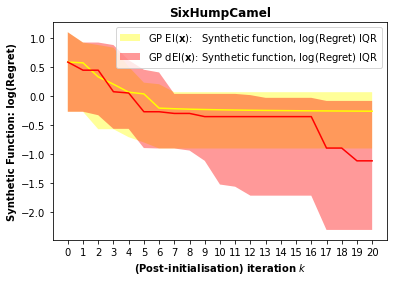

In [163]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


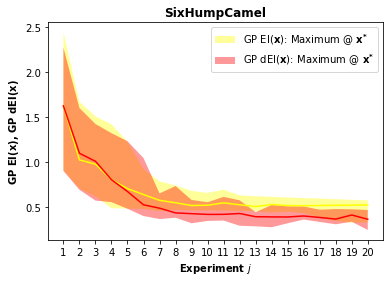

In [164]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approxAF, color = 'Yellow')
plt.plot(median_exactAF, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approxAF, upper_approxAF, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')
plt.fill_between(xstar, lower_exactAF, upper_exactAF, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Maximum @ $\mathbf{x^{*}}$')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI($\mathbf{x}$), GP dEI($\mathbf{x}$)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show() #visualise!


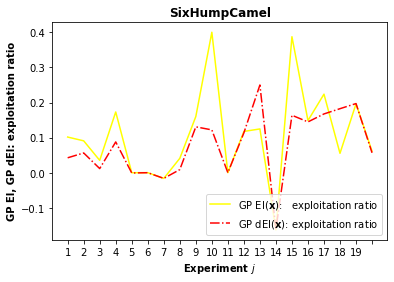

In [165]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(approx_ratio, color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio')
plt.plot(exact_ratio, color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=4) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


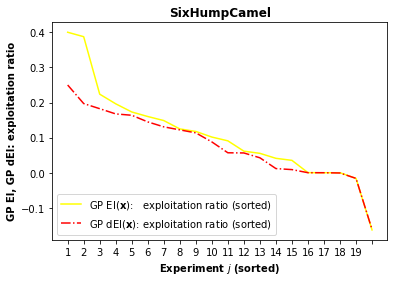

In [166]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(np.sort(approx_ratio)[::-1], color = 'Yellow', label='GP EI($\mathbf{x}$):   exploitation ratio (sorted)')
plt.plot(np.sort(exact_ratio)[::-1], color = 'Red', ls='-.', label='GP dEI($\mathbf{x}$): exploitation ratio (sorted)')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment $\it{j}$ (sorted)' , weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: exploitation ratio', weight = 'bold') # y-axis label
plt.legend(loc=3) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show()


In [167]:
np.sum((approx_1.start_points_arr - exact_1.start_points_arr)**2)


0.0

In [168]:
approx_mean_test, approx_var_test = surrogate_approx_1.predict(approx_1.start_points_arr,return_std=True)
approx_std_test = np.sqrt(approx_var_test + eps)
approx_mean_test, approx_std_test


(array([-66.38871596, -30.58269987, -12.48009104,  -2.71235658,
        -10.28613718, -20.0082798 , -21.24985556, -11.98291745,
        -13.65024617, -41.24592078, -11.13607941,  -2.72349222,
         -3.17928329, -50.75830992, -17.10628843, -26.83884572,
        -51.96018007, -20.7527687 , -17.68323618, -41.8951058 ]),
 array([1.80586327, 1.90297756, 1.95562818, 1.6959533 , 1.87396225,
        1.85764394, 1.77141557, 1.75102403, 1.72507149, 1.90249863,
        1.86688875, 1.54111454, 1.73867404, 1.89710038, 1.97835055,
        1.89395915, 1.70047445, 1.97188504, 1.9533773 , 1.92691542]))

In [169]:
exact_mean_test, exact_var_test = surrogate_exact_1.predict(exact_1.start_points_arr,return_std=True)
exact_std_test = np.sqrt(exact_var_test + eps)
np.round(exact_mean_test, 3), np.round(exact_std_test, 3)


(array([ -9.74 ,  -9.576, -39.718,  -0.728,  -7.01 ,  -9.035, -10.1  ,
         -7.714, -10.799, -10.258,  -8.166,  -2.311,  -0.832, -14.656,
        -50.895,  -9.772, -51.241, -46.163, -33.095, -41.898]),
 array([1.761, 1.752, 1.747, 1.498, 1.857, 1.763, 1.824, 1.706, 1.704,
        1.735, 1.901, 1.576, 1.537, 1.784, 1.78 , 1.752, 1.7  , 1.808,
        1.786, 1.904]))

In [170]:
-np.min(approx_1.f_best)

0.19978031318243075

In [171]:
-np.min(exact_1.f_best)

0.31641722000372274